# Anticipez les besoins en consommation de bâtiments

- **Objectif:** Ville de Seattle neutre en émissions de carbone en 2050
- Analyse sur la consommation et aux émissions des bâtiments **non destinés à l’habitation.**  
- Comparer une estimation avec des features classiques et avec la feature **ENERGYSTARScore**  
- Targets : **émissions de CO2** + **consommation totale d’énergie**

In [1]:
#Importation des librairies de base

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv(r"C:\Users\elodi\Downloads\2016_Building_Energy_Benchmarking.csv", sep = ",")

In [3]:
#Aperçu des informations du jeu de données

df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [4]:
#Aperçu des informations du jeu de données

df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

### I - Nettoyage des données

In [5]:
# Apercu du nombre de valeur unique par variable
df.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [6]:
count_unique = df.nunique()

# Filtrer les colonnes avec une seule valeur unique
columns_with_single_value = count_unique[count_unique == 1].index.tolist()

# Afficher les noms des colonnes avec leur valeur unique
for column in columns_with_single_value:
    unique_value = df[column].unique()[0]
    print(f"Colonne : {column}, Valeur unique : {unique_value}")

Colonne : DataYear, Valeur unique : 2016
Colonne : City, Valeur unique : Seattle
Colonne : State, Valeur unique : WA


In [7]:
# Suppression des colonnes vides
columns_with_only_nan = df.columns[df.isna().all()].tolist()
print("Colonnes avec uniquement des NaN :", columns_with_only_nan)

Colonnes avec uniquement des NaN : ['Comments']


#### Suppression lignes ne possédant pas de valeurs ENERGYSTARScore
Si on veut comparer avec la feature ENERGYSTARScore, il vaut mieux avoir toutes ces valeurs

In [8]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df.dropna(subset=['ENERGYSTARScore'], inplace=True)
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 3376
Nombre de lignes après la suppression : 2533


#### Suppression lignes ne possédant pas de valeurs pour les targets
On doit avoir toutes les valeurs pour le target TotalGHGEmissions, GHGEmissionsIntensity et SiteEnergyUseWN(kBtu) 

In [9]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df.dropna(subset=['TotalGHGEmissions'], inplace=True)
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 2533
Nombre de lignes après la suppression : 2533


In [10]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df.dropna(subset=['GHGEmissionsIntensity'], inplace=True)
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 2533
Nombre de lignes après la suppression : 2533


In [11]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df.dropna(subset=['SiteEnergyUseWN(kBtu)'], inplace=True)
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 2533
Nombre de lignes après la suppression : 2532


#### Suppression du nom des bâtiments
Le nom du bâtiment n'influence en rien sa consommation en C02

In [12]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(columns="PropertyName")
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 46
Nombre de colonnes après la suppression : 45


#### Suppression IDs

In [13]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(columns=['OSEBuildingID', 'TaxParcelIdentificationNumber'])
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 45
Nombre de colonnes après la suppression : 43


#### Suppression lignes avec des valeurs par défaut
Certaines lignes possèdent des valeurs artificielles, on peut le savoir grace a la colonne DefaultData qui donne True ou False

In [14]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df = df.drop(df[df['DefaultData'] == True].index)
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 2532
Nombre de lignes après la suppression : 2419


In [15]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop("DefaultData", axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 43
Nombre de colonnes après la suppression : 42


#### Suppression lignes avec des valeurs "Non Compliant"
Dans la colonne "ComplianceStatus", si on a "Non Compliant" cela signifie que ce bâtiment ne satisfait pas aux exigences de l'analyse de la consommation d'énergie

In [16]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df = df.drop(df[df['ComplianceStatus'] == "Non-Compliant"].index)
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 2419
Nombre de lignes après la suppression : 2398


In [17]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop("ComplianceStatus", axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 42
Nombre de colonnes après la suppression : 41


#### Supression colonne Outlier

In [18]:
# Obtenez toutes les valeurs uniques dans la colonne "ComplianceStatus"
unique_values = df["Outlier"].unique()

# Affichez toutes les valeurs uniques
print(unique_values)

[nan]


In [19]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop("Outlier", axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 41
Nombre de colonnes après la suppression : 40


#### Supression NaturalGas(kBtu)
NaturalGas(kBtu) et NaturalGas(therms) représentent la même chose, sauf que NaturalGas(therms) possède des valeurs légèrement plus précises  
22536.21094 (terms) contre 2253621.0 (kBtu) par exemple

In [20]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop("NaturalGas(kBtu)", axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 40
Nombre de colonnes après la suppression : 39


#### Supression Electricity(kWh)
Electricity(kWh) et	Electricity(kBtu) représentent la même chose mais la version kBtu possédant une précision a un chiffre après la virgule contrairement a kWh qui est uniquement en nombre entier  
1.156514e+06 (kWh)	3946027.0 (kBtu)

In [21]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop("Electricity(kWh)", axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 39
Nombre de colonnes après la suppression : 38


#### Supression (SiteEUI(kBtu/sf) et SiteEUIWN(kBtu/sf)) et (SourceEUI(kBtu/sf) et SourceEUIWN(kBtu/sf))
Notre target est la consommation totale d'énergie et non une consommation rapportée a la surface brute du plancher

In [22]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(columns=['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)'])
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 38
Nombre de colonnes après la suppression : 34


#### Supression SiteEnergyUse(kBtu)
SiteEnergyUseWN(kBtu) est une métrique plus précise que SiteEnergyUse(kBtu)

In [23]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(columns=['SiteEnergyUse(kBtu)'])
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 34
Nombre de colonnes après la suppression : 33


#### Supression GHGEmissionsIntensity
Notre target est TotalGHGEmissions (total consommation CO2), GHGEmissionsIntensity n'est pas à considérer

In [24]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(columns=['GHGEmissionsIntensity'])
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 33
Nombre de colonnes après la suppression : 32


#### Supression YearsENERGYSTARCertified
L'année dans lequel on a donné la certification ENERGYSTAR n'a aucune influence sur nos targets

#### Mettre SiteEnergyUseWN(kBtu) a la dernière colonne
Pour mieux voir les 2 targets, on met SiteEnergyUseWN(kBtu) à la fin

In [25]:
df = df[[col for col in df.columns if col != 'SiteEnergyUseWN(kBtu)'] + ['SiteEnergyUseWN(kBtu)']]

#### Supression lignes possédant des NaN

In [26]:
nan_counts = df.isna().sum()
nan_counts

DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
Address                               0
City                                  0
State                                 0
ZipCode                               0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                7
LargestPropertyUseTypeGFA             7
SecondLargestPropertyUseType       1292
SecondLargestPropertyUseTypeGFA    1292
ThirdLargestPropertyUseType        2122
ThirdLargestPropertyUseTypeGFA     2122
YearsENERGYSTARCertified           2281


In [27]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df.dropna(subset=['LargestPropertyUseType', 'LargestPropertyUseTypeGFA'], inplace=True)
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 2398
Nombre de lignes après la suppression : 2391


#### Récupérations des bâtiments non destinés à l'habitation

In [28]:
# Recenser toutes les valeurs uniques dans la colonne "BuildingType"
building_types = df["BuildingType"].unique()

# Afficher les valeurs uniques de la colonne "BuildingType"
print(building_types)

['NonResidential' 'Multifamily MR (5-9)' 'Campus' 'SPS-District K-12'
 'Multifamily LR (1-4)' 'Nonresidential COS' 'Multifamily HR (10+)']


- **NonResidential**: Il s'agit d'un type de bâtiment qui n'est pas résidentiel
- **Nonresidential COS**: "Commercial/Office Space" (espace commercial/bureaux)
- **Multifamily MR**: Bâtiments résidentiels multifamiliaux de taille moyenne
- **SPS-District K-12**:"Seattle Public Schools" (Écoles publiques de Seattle).
- **Campus**: Institution éducative, une entreprise ou une organisation.
- **Nonresidential WA**: "Warehouse" (entrepôt)

On va par conséquent supprimer les lignes ou les bâtiments sont résidentiels:
- Multifamily MR (5-9)
- Multifamily LR (1-4)
- Multifamily HR (10+)

In [29]:
print("Nombre de lignes avant la suppression :", df.shape[0])

values_to_exclude = ['Multifamily MR (5-9)', 'Multifamily LR (1-4)', 'Multifamily HR (10+)']
df = df[~df['BuildingType'].isin(values_to_exclude)]

print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 2391
Nombre de lignes après la suppression : 994


### II - Analyse des Indicateurs d'Usage des bâtiments

In [30]:
#### 1 - Usage majoritaire (Largest Use Type)

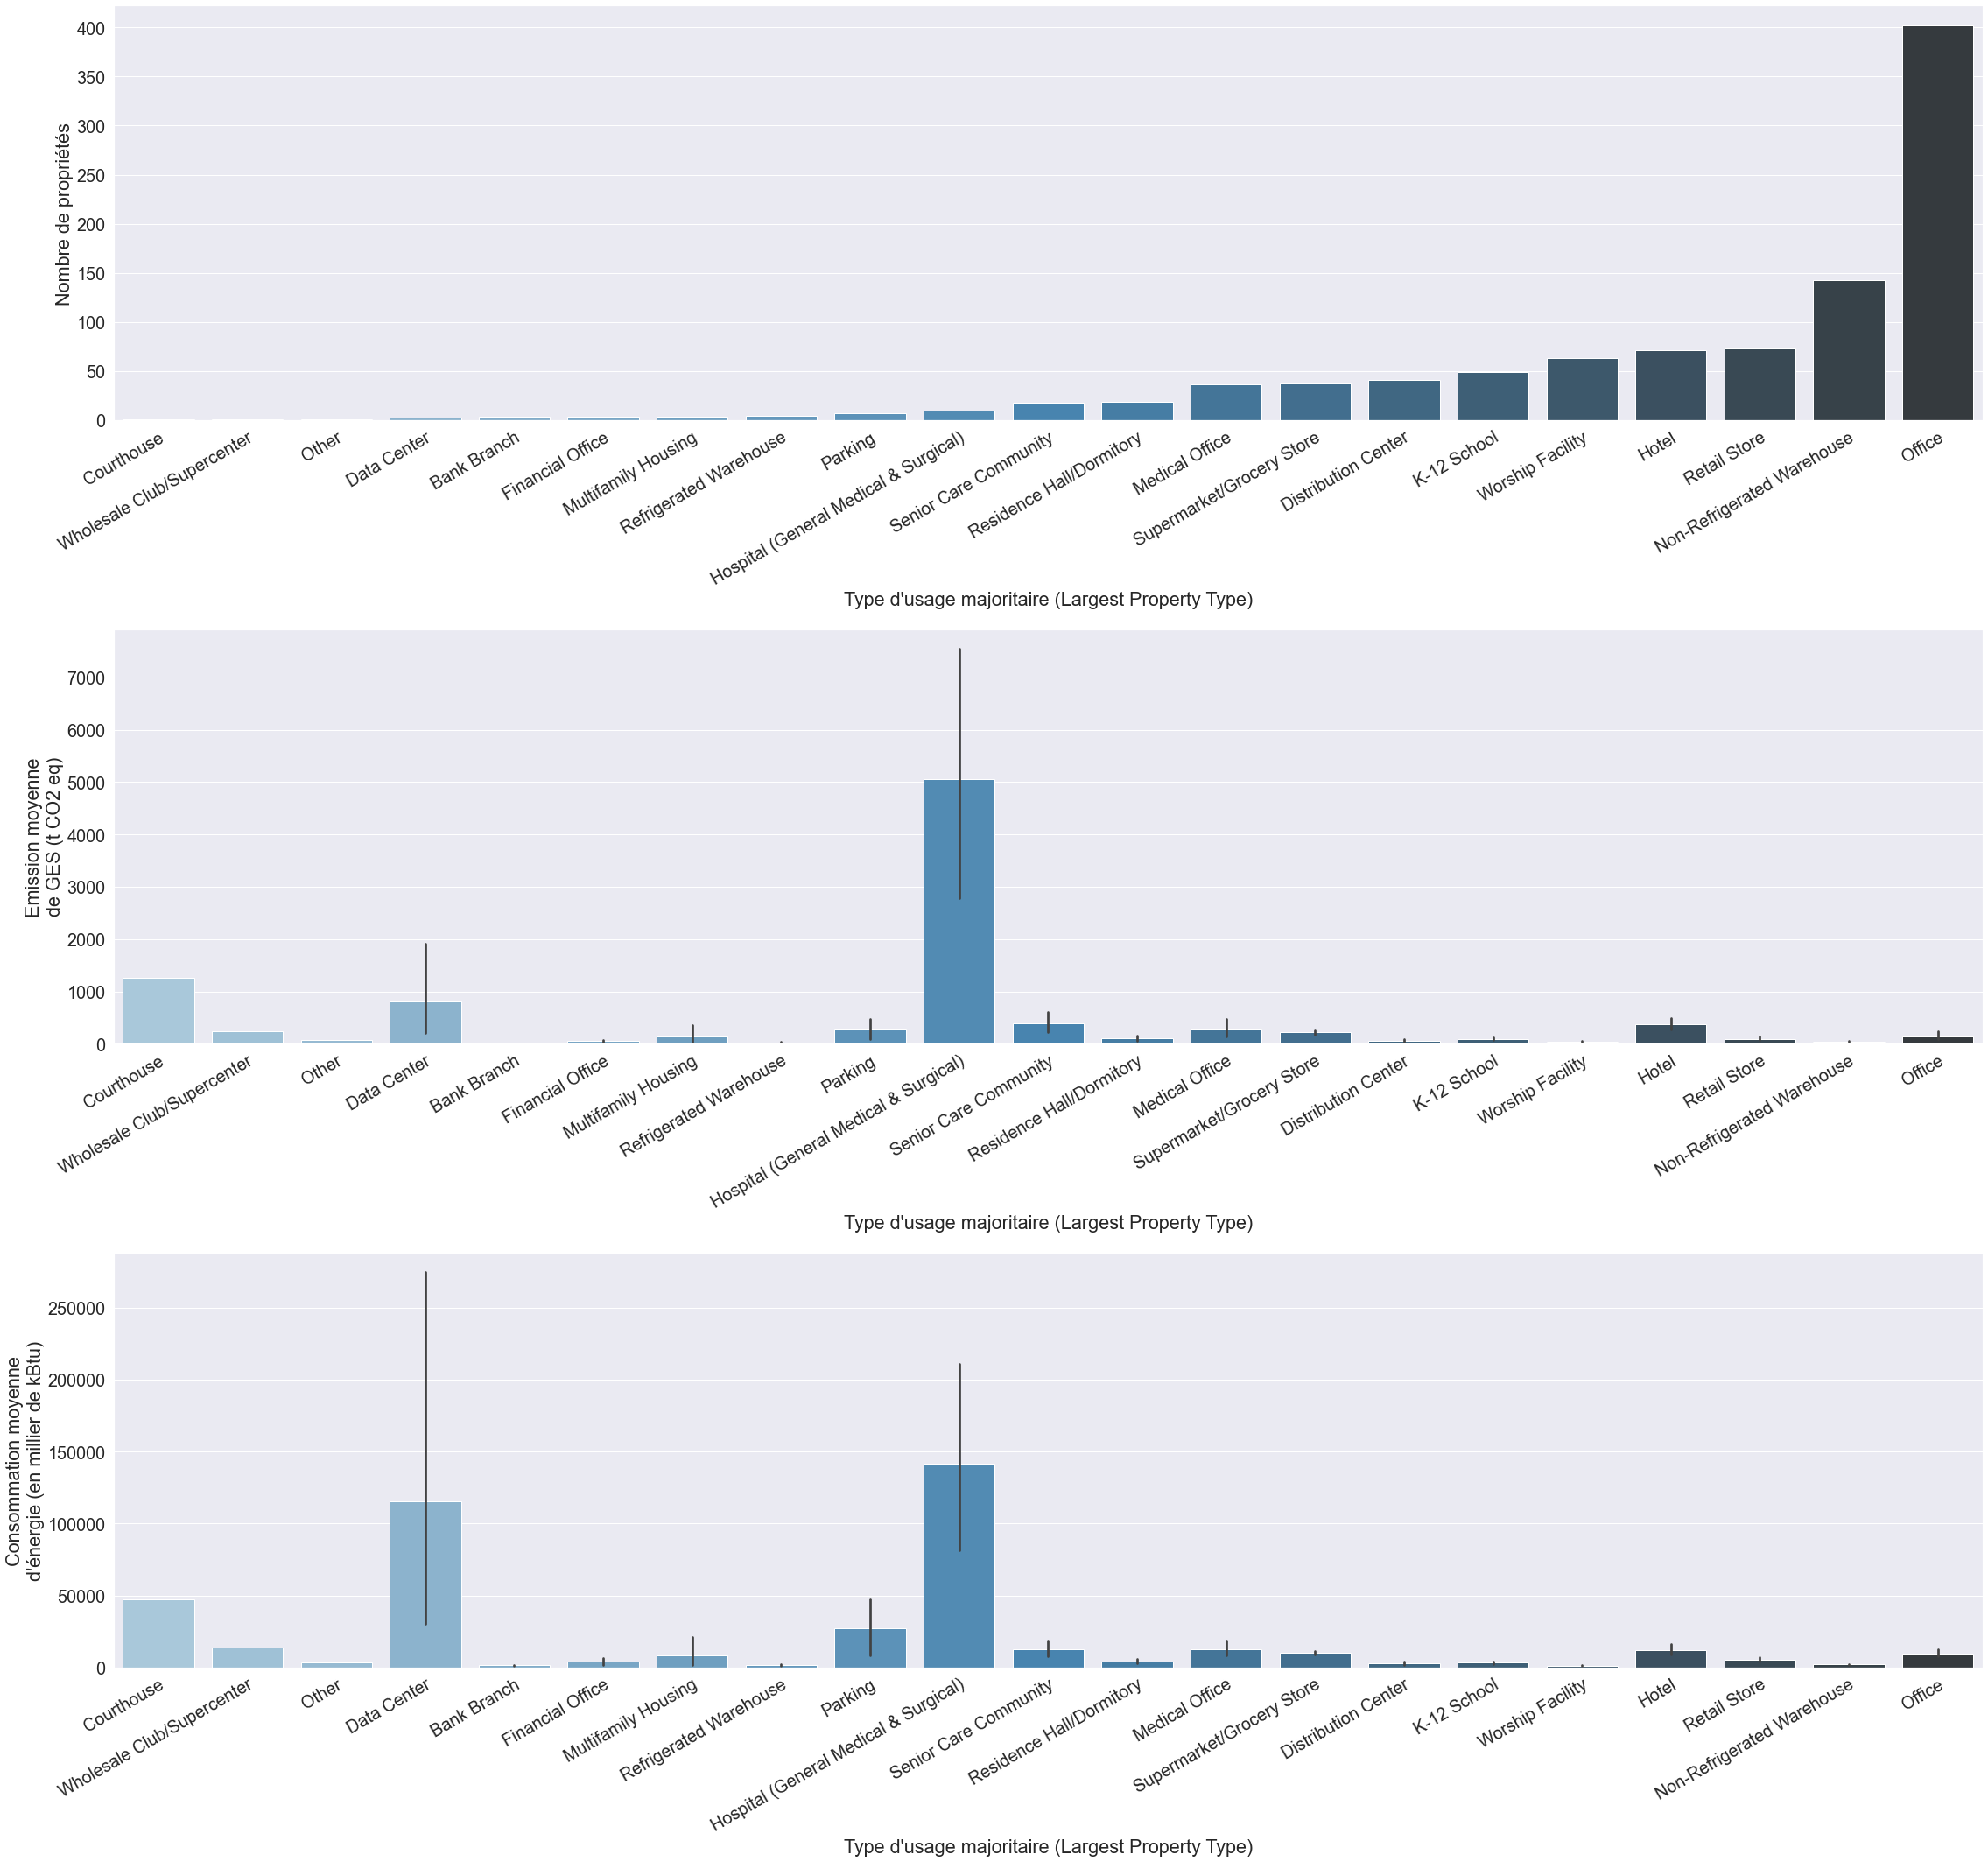

In [31]:
### Largest Use Type

sns.set(font_scale=1.8)


order = df['LargestPropertyUseType'].groupby(df['LargestPropertyUseType']).count().sort_values().index


fig, axes = plt.subplots(nrows= 3,figsize=(32, 30))

sns.barplot(x=df['LargestPropertyUseType'].groupby(df['LargestPropertyUseType']).count().sort_values().index,
            y=df['LargestPropertyUseType'].groupby(df['LargestPropertyUseType']).count().sort_values(),
            palette="Blues_d",
              ax=axes[0]
                 )

sns.barplot(x=df['LargestPropertyUseType'],
                 y=df['TotalGHGEmissions'],
                 order=order,
                 data=df,
                 palette="Blues_d",
                 ax=axes[1])

sns.barplot(x=df['LargestPropertyUseType'],
                y=df['SiteEnergyUseWN(kBtu)']/1000,
                order=order,
                data=df,
                palette="Blues_d",
                ax=axes[2])


    
for i in range (3):
    axes[i].set_xlabel("Type d'usage majoritaire (Largest Property Type)")  
    axes[i].set_xticklabels( axes[i].get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor' )

axes[0].set_ylabel("Nombre de propriétés")
axes[1].set_ylabel("Emission moyenne""\n""de GES (t CO2 eq)")
axes[2].set_ylabel("Consommation moyenne""\n""d'énergie (en millier de kBtu)")

plt.tight_layout()
plt.show()

#### 2 - Usage Primaire (Primary Use Type)
L'utilisation Primaire reprend globalement l'information de l'utilisation majoritaire réunie en groupes plus synthétiques

In [32]:
print(df['PrimaryPropertyType'].sort_values().unique())

['Distribution Center' 'Hospital' 'Hotel' 'K-12 School' 'Large Office'
 'Low-Rise Multifamily' 'Medical Office' 'Mixed Use Property' 'Other'
 'Refrigerated Warehouse' 'Residence Hall' 'Retail Store'
 'Senior Care Community' 'Small- and Mid-Sized Office'
 'Supermarket / Grocery Store' 'Warehouse' 'Worship Facility']


In [33]:
df['PrimaryPropertyType'].groupby(df['PrimaryPropertyType']).count().sort_values()

PrimaryPropertyType
Low-Rise Multifamily             1
Refrigerated Warehouse           5
Hospital                        10
Other                           11
Senior Care Community           18
Residence Hall                  19
Mixed Use Property              26
Medical Office                  37
Supermarket / Grocery Store     39
Distribution Center             40
K-12 School                     49
Worship Facility                63
Hotel                           71
Retail Store                    72
Warehouse                      141
Large Office                   159
Small- and Mid-Sized Office    233
Name: PrimaryPropertyType, dtype: int64

In [34]:
# Aggrégation des groupes de bureaux
df['PrimaryPropertyType'].replace(['Small- and Mid-Sized Office','Large Office'],'Office', inplace=True)

In [35]:
# L'avantage de la variable "PrimaryPropertyType" est d'avoir des grands groupes de bâtiments. 
# Cependant, certains groupes peuvent être trop hétérogènes (dans leur consommation electrique par exemple), 
# pouvant affecter la modélisation par la suite.
# C'est le cas des Data Center, qui ont une conso. energétique très importante.

# La ligne ci-dessous remplace la valeur PrimaryPropertyTYpe des Data center par Data Center.
df['PrimaryPropertyType'] = np.where(df['LargestPropertyUseType'].str.contains("Data Center", case=False, na=np.nan) == True,"Data Center", df['PrimaryPropertyType'])


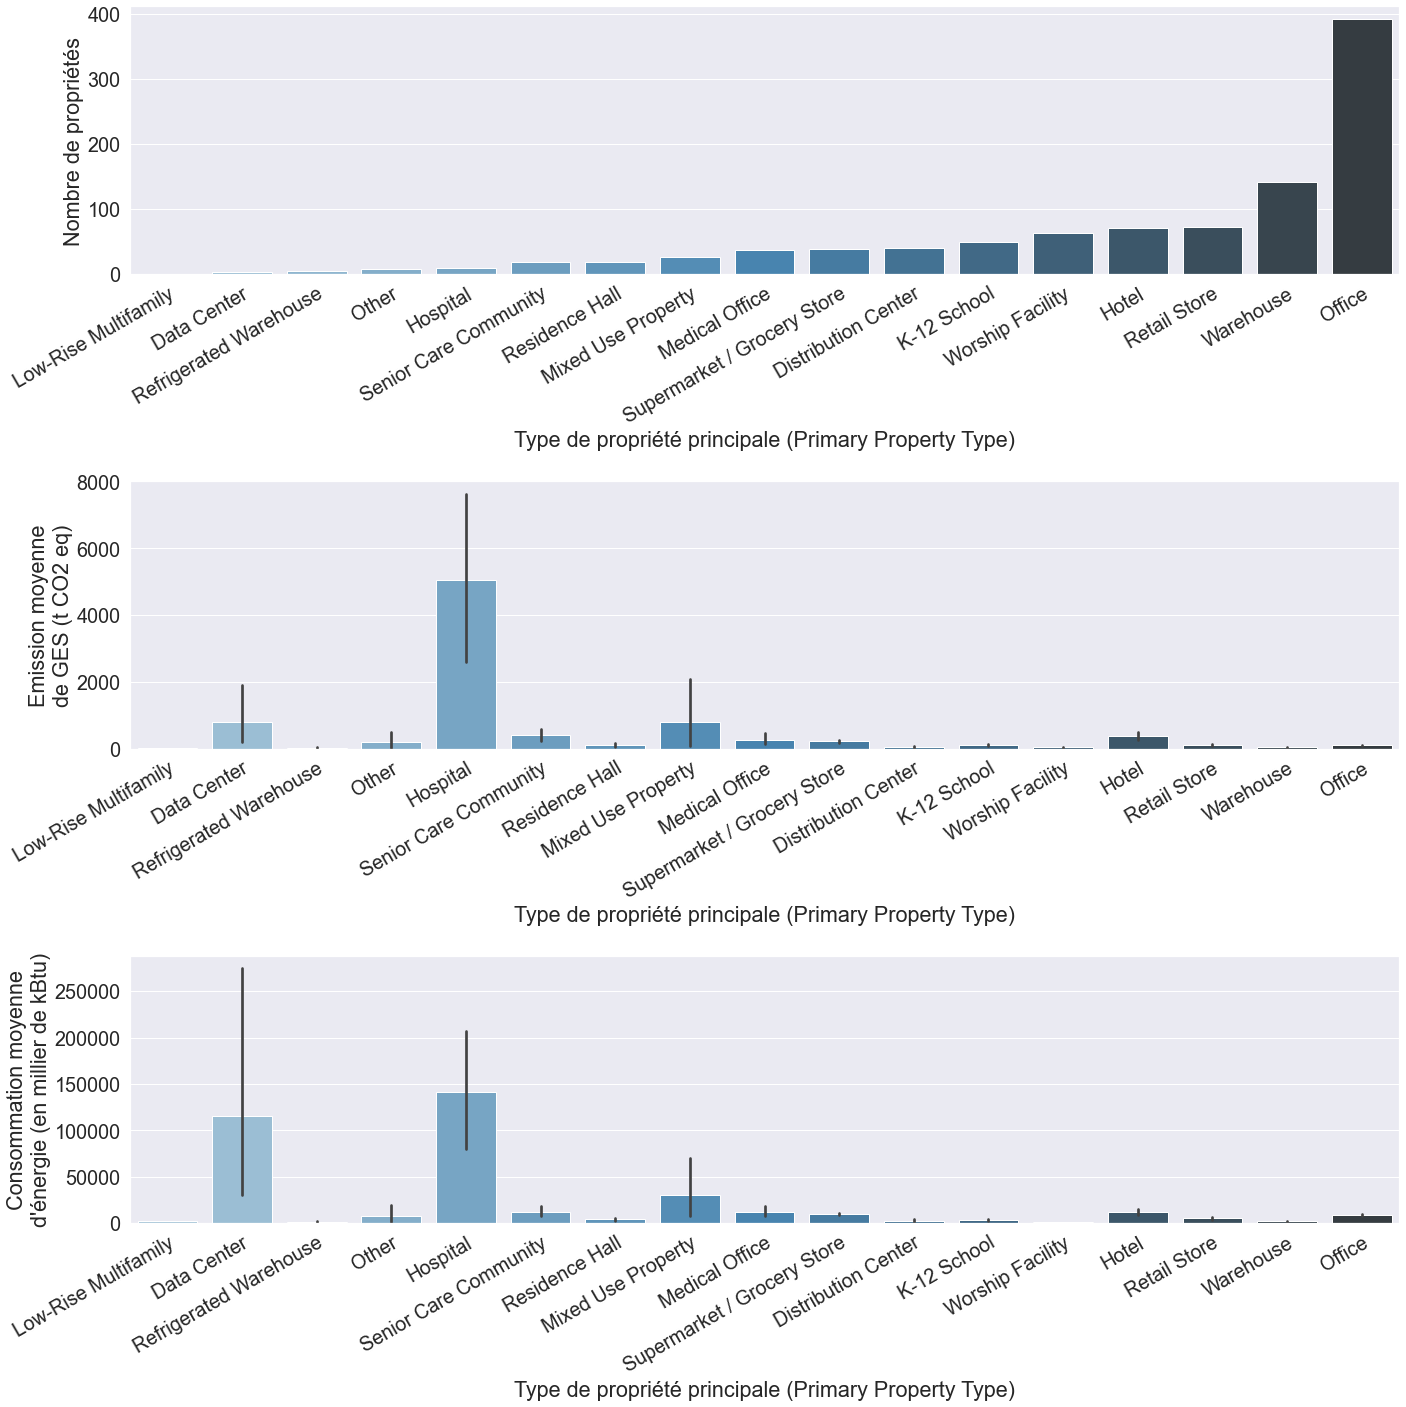

In [36]:
sns.set(font_scale=1.8)


order_P = df['PrimaryPropertyType'].groupby(df['PrimaryPropertyType']).count().sort_values().index


fig, axes = plt.subplots(nrows= 3,figsize=(20, 20))

sns.barplot(x=df['PrimaryPropertyType'].groupby(df['PrimaryPropertyType']).count().sort_values().index,
            y=df['PrimaryPropertyType'].groupby(df['PrimaryPropertyType']).count().sort_values(),
              ax=axes[0],
              palette="Blues_d"
            )

sns.barplot(x=df['PrimaryPropertyType'],
                 y=df['TotalGHGEmissions'],
                 order=order_P,
                 data=df,palette="Blues_d",
                 ax=axes[1])

sns.barplot(x=df['PrimaryPropertyType'],
                y=df['SiteEnergyUseWN(kBtu)']/1000,
                order=order_P,
                data=df,palette="Blues_d",
                ax=axes[2])


    
for i in range (3):
    axes[i].set_xlabel('Type de propriété principale (Primary Property Type)')  
    axes[i].set_xticklabels( axes[i].get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor' )

axes[0].set_ylabel("Nombre de propriétés")
axes[1].set_ylabel("Emission moyenne""\n""de GES (t CO2 eq)")
axes[2].set_ylabel("Consommation moyenne""\n""d'énergie (en millier de kBtu)")

plt.tight_layout()
plt.show()

### III- Analyse des indicateurs Géographiques

#### 1- Neighborhood      

In [37]:
df['Neighborhood'].groupby(df['Neighborhood']).count().sort_values()

Neighborhood
Central                    2
Ballard                    3
Delridge                   3
North                      3
Northwest                  4
SOUTHWEST                 18
SOUTHEAST                 21
DELRIDGE                  24
CENTRAL                   25
NORTH                     31
BALLARD                   33
NORTHWEST                 51
EAST                      66
NORTHEAST                 80
MAGNOLIA / QUEEN ANNE     87
LAKE UNION               101
GREATER DUWAMISH         200
DOWNTOWN                 242
Name: Neighborhood, dtype: int64

In [38]:
# Il y a un mélange de différentes formes typographique (Casses) pour les différents quartiers
df['Neighborhood'] = df['Neighborhood'].str.upper() 

In [39]:
# Remplacement de DELRIDGE NEIGHBORHOODS par DELRIDGE
df['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS','DELRIDGE', inplace=True)
df['Neighborhood'].groupby(df['Neighborhood']).count().sort_values()

Neighborhood
SOUTHWEST                 18
SOUTHEAST                 21
CENTRAL                   27
DELRIDGE                  27
NORTH                     34
BALLARD                   36
NORTHWEST                 55
EAST                      66
NORTHEAST                 80
MAGNOLIA / QUEEN ANNE     87
LAKE UNION               101
GREATER DUWAMISH         200
DOWNTOWN                 242
Name: Neighborhood, dtype: int64

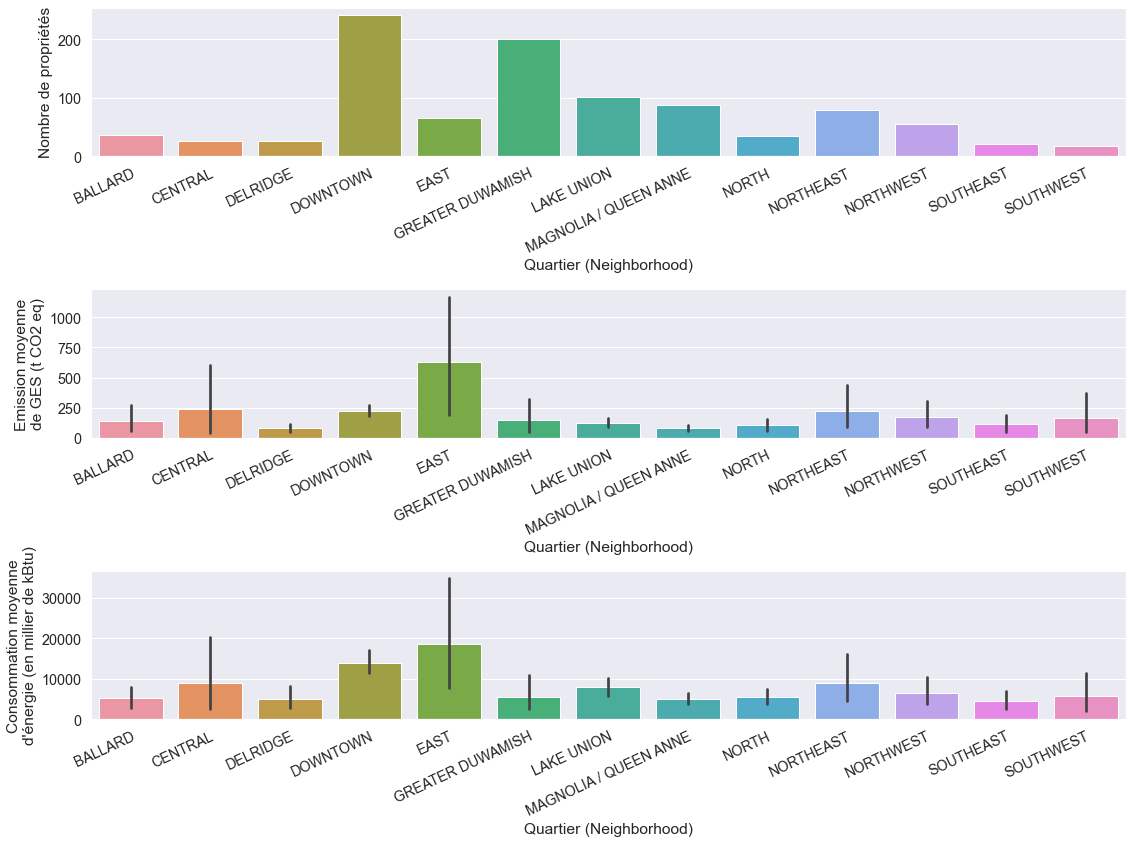

In [40]:
# Représentations graphiques de nombre de propriétés, la conso moyenne et les émissions de GES moyennes par quartier

sns.set(font_scale=1.3)


order_N = df['Neighborhood'].groupby(df['Neighborhood']).count().index


fig, axes = plt.subplots(nrows= 3,figsize=(16, 12))

sns.barplot(x=df['Neighborhood'].groupby(df['Neighborhood']).count().index,
                 y=df['Neighborhood'].groupby(df['Neighborhood']).count(),
                 ax=axes[0]
                 #palette="Blues_d",
                 #data=df
                 )

sns.barplot(x=df['Neighborhood'],
                 y=df['TotalGHGEmissions'],
                #palette="Blues_d",
                 order=order_N,
                 data=df,
                 ax=axes[1])

sns.barplot(x=df['Neighborhood'],
                y=df['SiteEnergyUseWN(kBtu)']/1000,
                #palette="Blues_d",
                order=order_N,
                data=df,
                ax=axes[2])


    
for i in range (3):
    axes[i].set_xticklabels( axes[i].get_xticklabels(), rotation=25, ha='right', rotation_mode='anchor' )
    axes[i].set_xlabel('Quartier (Neighborhood)')

axes[0].set_ylabel("Nombre de propriétés")
axes[1].set_ylabel("Emission moyenne""\n""de GES (t CO2 eq)")
axes[2].set_ylabel("Consommation moyenne""\n""d'énergie (en millier de kBtu)")

plt.tight_layout()
plt.show()

#### 2 - CouncilDistrictCode

In [41]:
df['CouncilDistrictCode'] = df['CouncilDistrictCode'].astype(str)

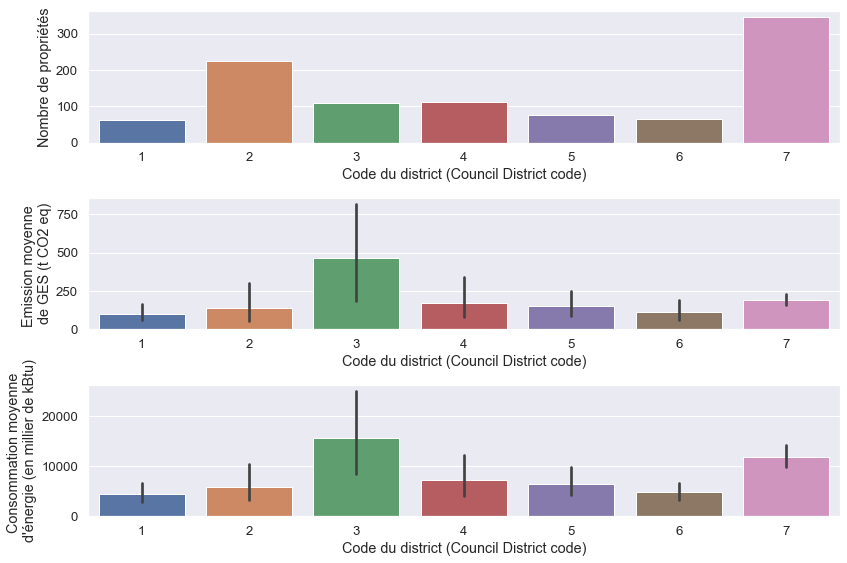

In [42]:
# Représentations graphiques de nombre de propriétés, la conso moyenne et les émissions de GES moyennes par District

sns.set(font_scale=1.2)

order_C = df['CouncilDistrictCode'].groupby(df['CouncilDistrictCode']).count().index

fig, axes = plt.subplots(nrows= 3,figsize=(12, 8))

sns.barplot(x=df['CouncilDistrictCode'].groupby(df['CouncilDistrictCode']).count().index,
                 y=df['CouncilDistrictCode'].groupby(df['CouncilDistrictCode']).count(),
                 ax=axes[0]
                 )

sns.barplot(x=df['CouncilDistrictCode'],
                 y=df['TotalGHGEmissions'],
                 order=order_C,
                 data=df,
                 ax=axes[1])

sns.barplot(x=df['CouncilDistrictCode'],
                y=df['SiteEnergyUseWN(kBtu)']/1000,
                order=order_C,
                data=df,
                ax=axes[2])

for i in range (3):
    axes[i].set_xlabel('Code du district (Council District code)')

axes[0].set_ylabel("Nombre de propriétés")
axes[1].set_ylabel("Emission moyenne"" \n""de GES (t CO2 eq)")
axes[2].set_ylabel("Consommation moyenne"" \n""d'énergie (en millier de kBtu)")


plt.tight_layout()
plt.show()


#### 3 - Longitude et Latitude

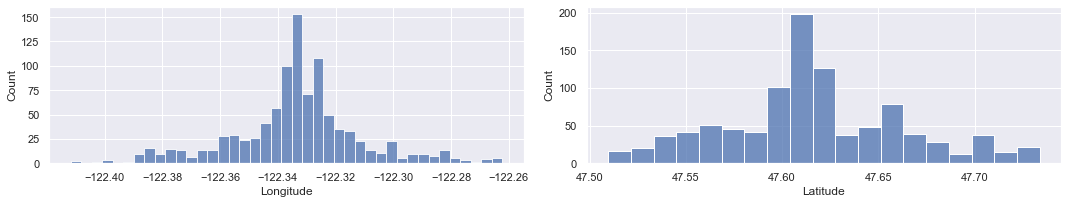

In [43]:
sns.set(font_scale=1)
fig, axes = plt.subplots(ncols = 2,figsize=(15, 3))
g=sns.histplot(df, x="Longitude",cbar=True, 
               #bins=25, 
               ax=axes[0])
g2=sns.histplot(df, x="Latitude",cbar=True,
                #bins=25,
                ax=axes[1])
plt.tight_layout()

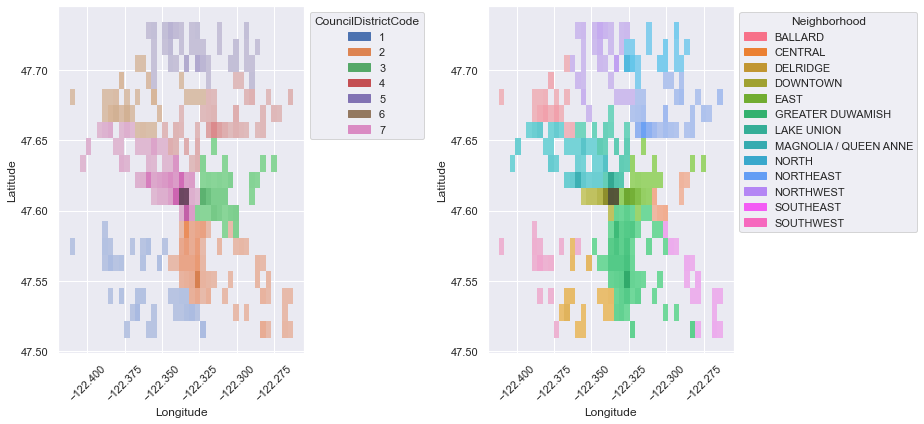

In [44]:
sns.set(font_scale=1)
fig, axes = plt.subplots(ncols = 2,figsize=(13, 6))
g=sns.histplot(df, x="Longitude", y="Latitude",
               hue=df["CouncilDistrictCode"].astype("string"),
               hue_order=order_C,
               label=list(df["CouncilDistrictCode"].astype("string").unique()),
               ax=axes[0])
g2=sns.histplot(df, x="Longitude", y="Latitude",
               hue=df["Neighborhood"].astype("string"),
               hue_order=order_N,
               label=list(df["Neighborhood"].astype("string").unique()),
               ax=axes[1])

sns.move_legend(axes[0], "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(axes[1], "upper left", bbox_to_anchor=(1, 1))

axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)


plt.tight_layout()

### IV- Analyse des Indicateurs Architecturaux

In [45]:
# Création d'une colonne montrant le rapport entre la taille du parking et la taille totale. 
df['Parking_per']=(df['PropertyGFAParking']/df['PropertyGFATotal']).round(3)

# Création d'une colonne montrant le rapport entre la taille d'usage majoritaire et la taille totale. 
df['Largest_UseType_per']=(df['LargestPropertyUseTypeGFA']/df['PropertyGFATotal']).round(3)

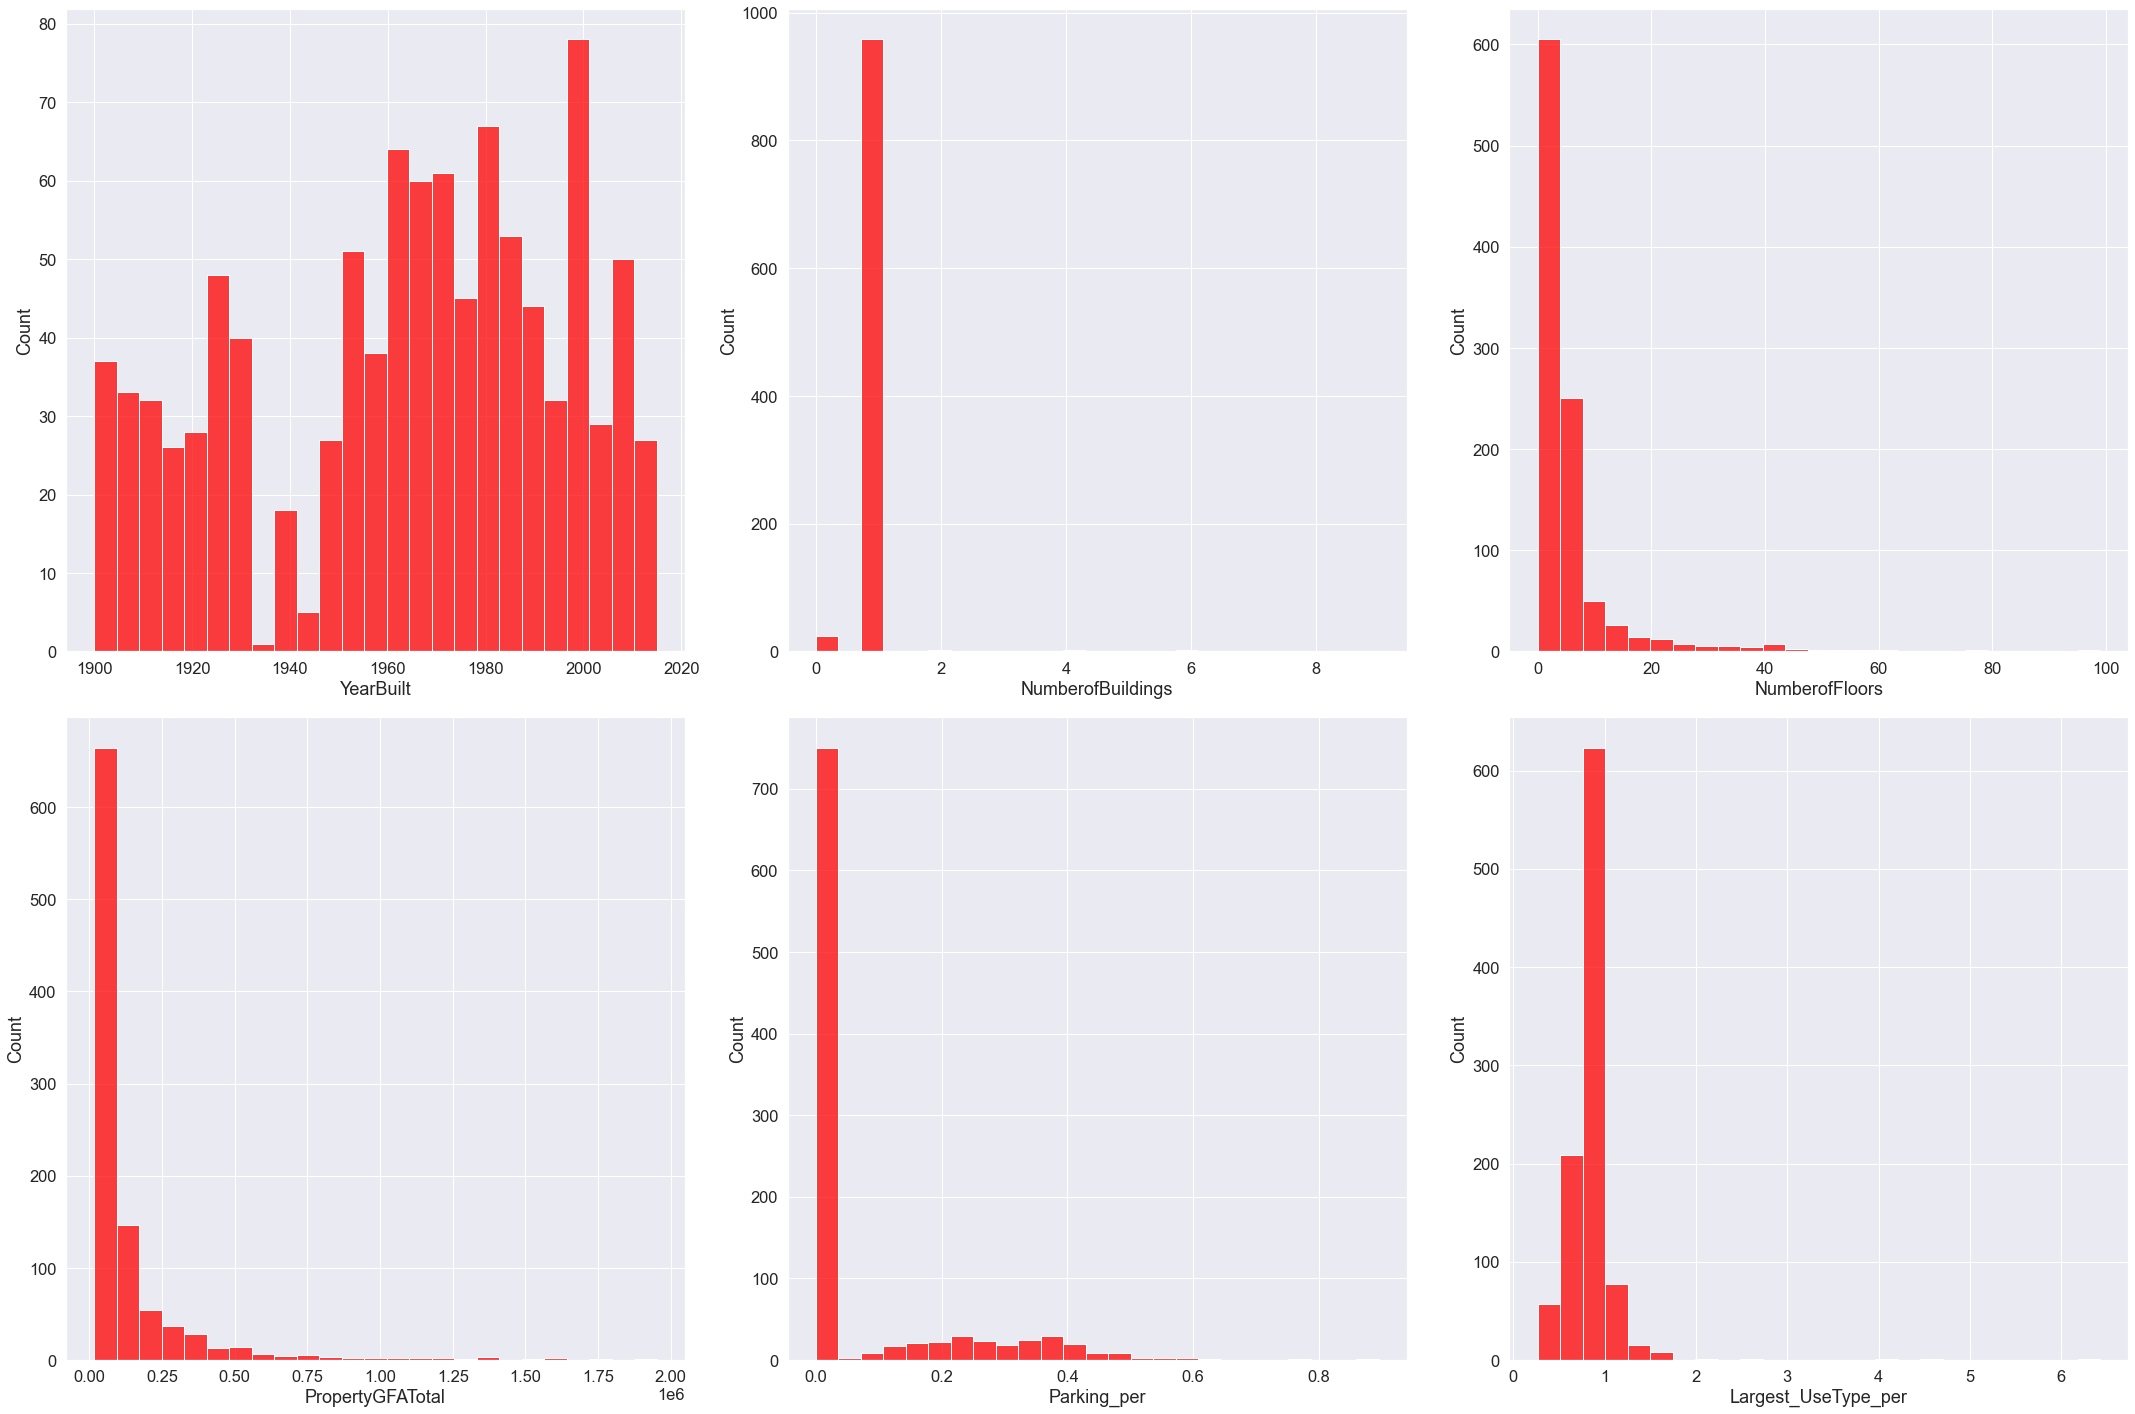

In [46]:
# Répartition empirique des indicateurs architecturaux 
lst_variables = ['YearBuilt','NumberofBuildings','NumberofFloors','PropertyGFATotal','Parking_per','Largest_UseType_per']

n=len(lst_variables)

sns.set(font_scale=1.5)

plt.figure(figsize=(30,20))

for i in range(n):
    col = lst_variables[i]
    ax = plt.subplot(2, 3, i + 1)
    sns.histplot(data=df, x=col,
                 bins=25, 
                 color="red")

plt.tight_layout()

In [47]:
# Le ratio Largest_UseType_per doit être inférieure à 1 
# (la taille totale de la propriété ne peut etre inferieur à la taille d'usage principale).
# Les ratios > 1 montrent des erreurs dans la mesure de la surface totale. 

df = df[df['Largest_UseType_per'] <= 1]

In [48]:
df[lst_variables].describe()

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
count   880.000000         880.000000      880.000000      8.800000e+02   
mean   1962.628409           0.992045        5.279545      1.324547e+05   
std      32.377704           0.307184        8.400880      2.172152e+05   
min    1900.000000           0.000000        0.000000      2.000000e+04   
25%    1930.750000           1.000000        2.000000      3.200650e+04   
50%    1968.000000           1.000000        3.000000      5.583700e+04   
75%    1988.000000           1.000000        5.000000      1.288500e+05   
max    2015.000000           7.000000       99.000000      1.952220e+06   

       Parking_per  Largest_UseType_per  
count   880.000000           880.000000  
mean      0.078676             0.844238  
std       0.144309             0.180617  
min       0.000000             0.265000  
25%       0.000000             0.710750  
50%       0.000000             0.927000  
75%       0.123000             1.000000  
max       0.771000             1.000000

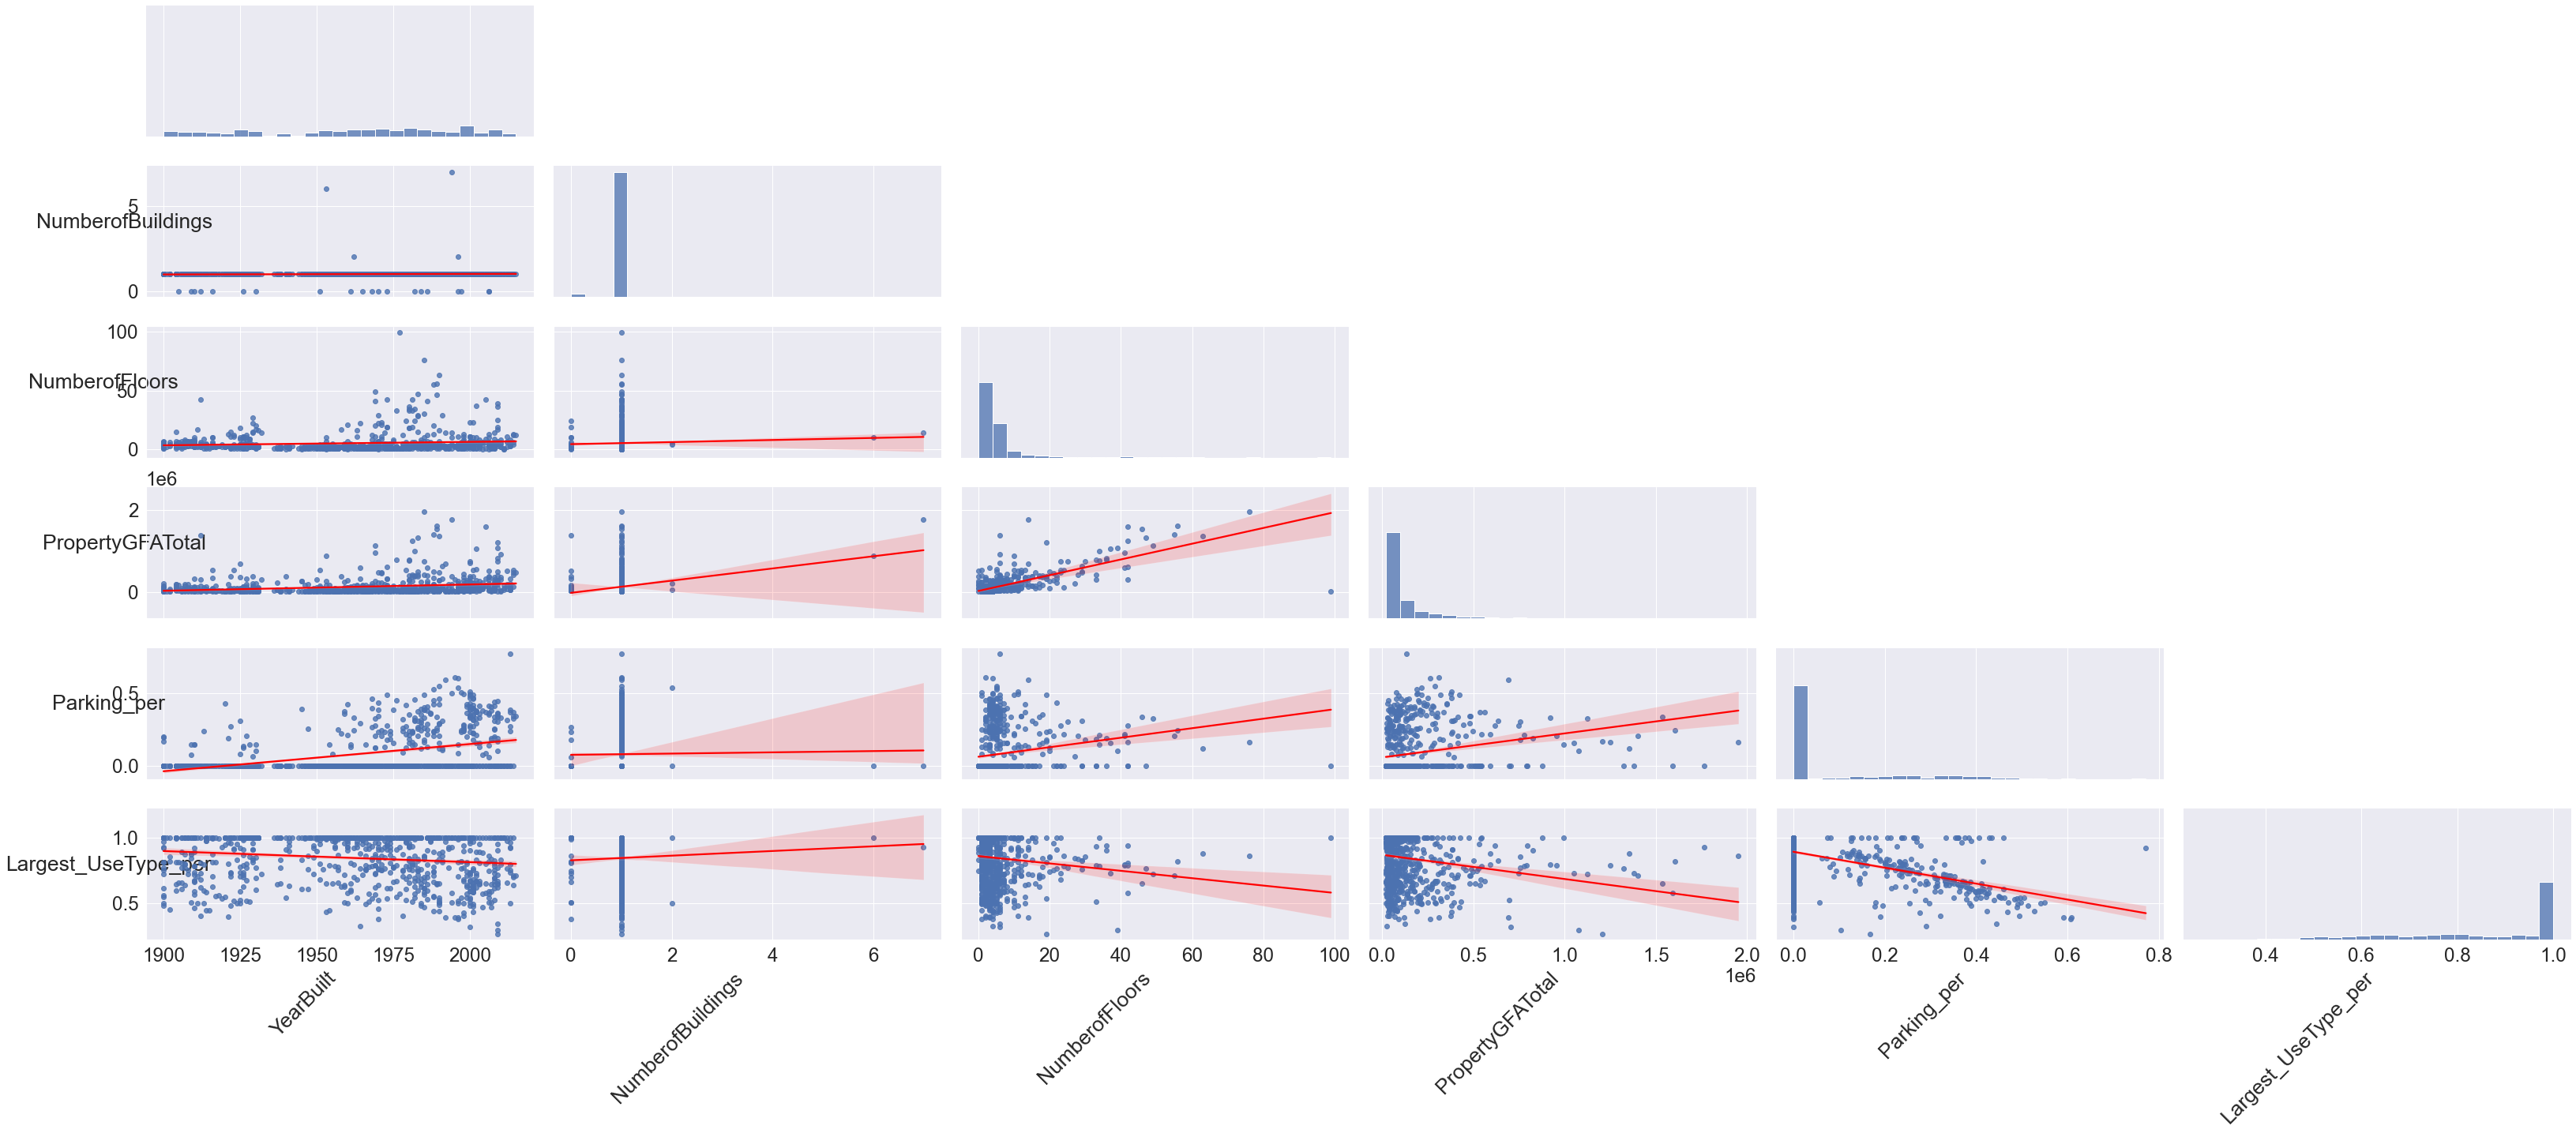

In [49]:
# Analyse de la relation entre les variables architecturales (pairplot)

sns.set(font_scale=2.2)

g = sns.pairplot(df[lst_variables], corner=True,kind='reg',plot_kws={'line_kws':{'color':'red'}},
                diag_kind = "hist", diag_kws = {'bins':25},height=3, aspect=2.5)
                
for ax in g.axes.flatten():
    if ax:
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation = 45)
        # rotate y axis labels
        # set y labels alignment
        ax.yaxis.get_label().set_horizontalalignment('right')
        # set x labels alignment
        ax.set_ylabel(ax.get_ylabel(), rotation = 0)
        ax.xaxis.get_label().set_horizontalalignment('right')

In [50]:
df[(df['NumberofBuildings'] == 111) | (df['NumberofFloors'] == 99)].T

1359
DataYear                                             2016
BuildingType                               NonResidential
PrimaryPropertyType                      Worship Facility
Address                          5801 Beacon Avenue South
City                                              Seattle
State                                                  WA
ZipCode                                           98108.0
CouncilDistrictCode                                     2
Neighborhood                             GREATER DUWAMISH
Latitude                                         47.55072
Longitude                                      -122.30265
YearBuilt                                            1977
NumberofBuildings                                     1.0
NumberofFloors                                         99
PropertyGFATotal                                    21948
PropertyGFAParking                                      0
PropertyGFABuilding(s)                              21948
ListOfAllPropertyUseTypes                Worship Facility
LargestPropertyUseType                   Worship Facility
LargestPropertyUseTypeGFA                         21948.0
SecondLargestPropertyUseType                          NaN
SecondLargestPropertyUseTypeGFA                       NaN
ThirdLargestPropertyUseType                           NaN
ThirdLargestPropertyUseTypeGFA                        NaN
YearsENERGYSTARCertified                              NaN
ENERGYSTARScore                                      80.0
SteamUse(kBtu)                                        0.0
Electricity(kBtu)                                326001.0
NaturalGas(therms)                                    0.0
Comments                                              NaN
TotalGHGEmissions                                    2.27
SiteEnergyUseWN(kBtu)                         326001.1875
Parking_per                                           0.0
Largest_UseType_per                                   1.0

In [51]:
# On relève 1 outlier. cette ropriétés sera retiré afin de ne pas impacter la modélisation par la suite. 

df[(df['NumberofBuildings'] == 111) | (df['NumberofFloors'] == 99)].T

df = df[(df['NumberofBuildings'] < 111) & (df['NumberofFloors'] < 99)]

### V-  Analyse des variables à prédire : SiteEnergyUseWN(kBtu) + TotalGHGEmissions

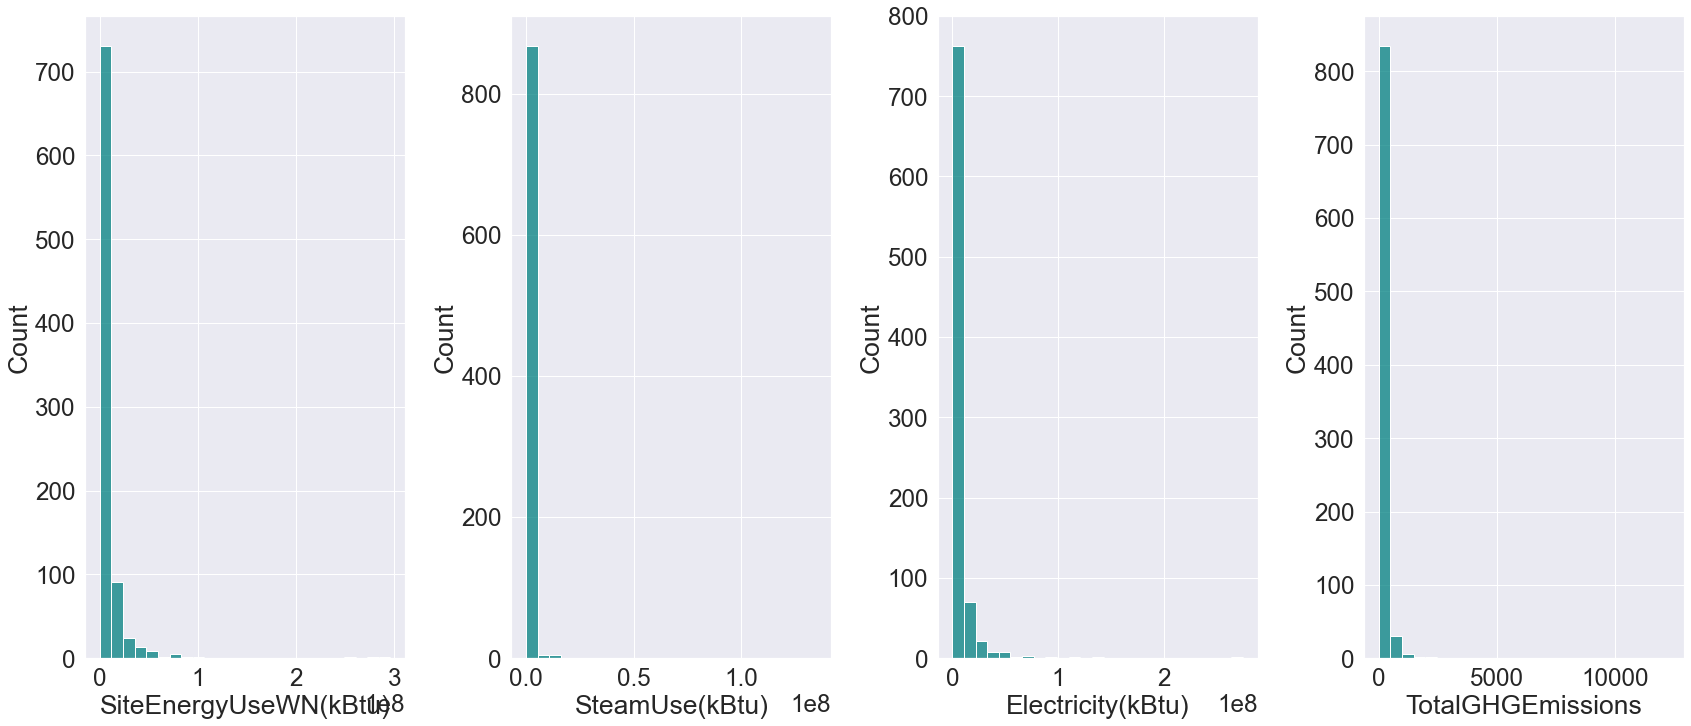

In [52]:
lst_Columns =  [
               'SiteEnergyUseWN(kBtu)',
               'SteamUse(kBtu)',
               'Electricity(kBtu)',
               'TotalGHGEmissions']

n=len(lst_Columns)

plt.figure(figsize=(30,20))

for i in range(n):
    col = lst_Columns[i]
    ax = plt.subplot(2, 5, i + 1)
    sns.histplot(data=df, x=col,
                 bins=25, 
                 color="teal")

plt.tight_layout()

In [53]:
df[lst_Columns].describe()

SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kBtu)  \
count           8.790000e+02    8.790000e+02       8.790000e+02   
mean            8.043247e+06    4.245751e+05       5.974071e+06   
std             1.945972e+07    4.847551e+06       1.436526e+07   
min             0.000000e+00    0.000000e+00      -1.154170e+05   
25%             1.329995e+06    0.000000e+00       7.972445e+05   
50%             2.934339e+06    0.000000e+00       1.887893e+06   
75%             7.792178e+06    0.000000e+00       5.670866e+06   
max             2.959299e+08    1.349435e+08       2.745325e+08   

       TotalGHGEmissions  
count         879.000000  
mean          152.882071  
std           553.168602  
min            -0.800000  
25%            20.110000  
50%            49.580000  
75%           135.015000  
max         12307.160000

In [54]:
#Retrait des bâtiments qui ont une consommation ou des émissions nuls ou inferieures à 0 (producteurs d'energie)
df[(df['SiteEnergyUseWN(kBtu)'] <= 0) | (df['TotalGHGEmissions'] <= 0)].T

df =df[(df['SiteEnergyUseWN(kBtu)'] > 0) & (df['TotalGHGEmissions'] > 0)]

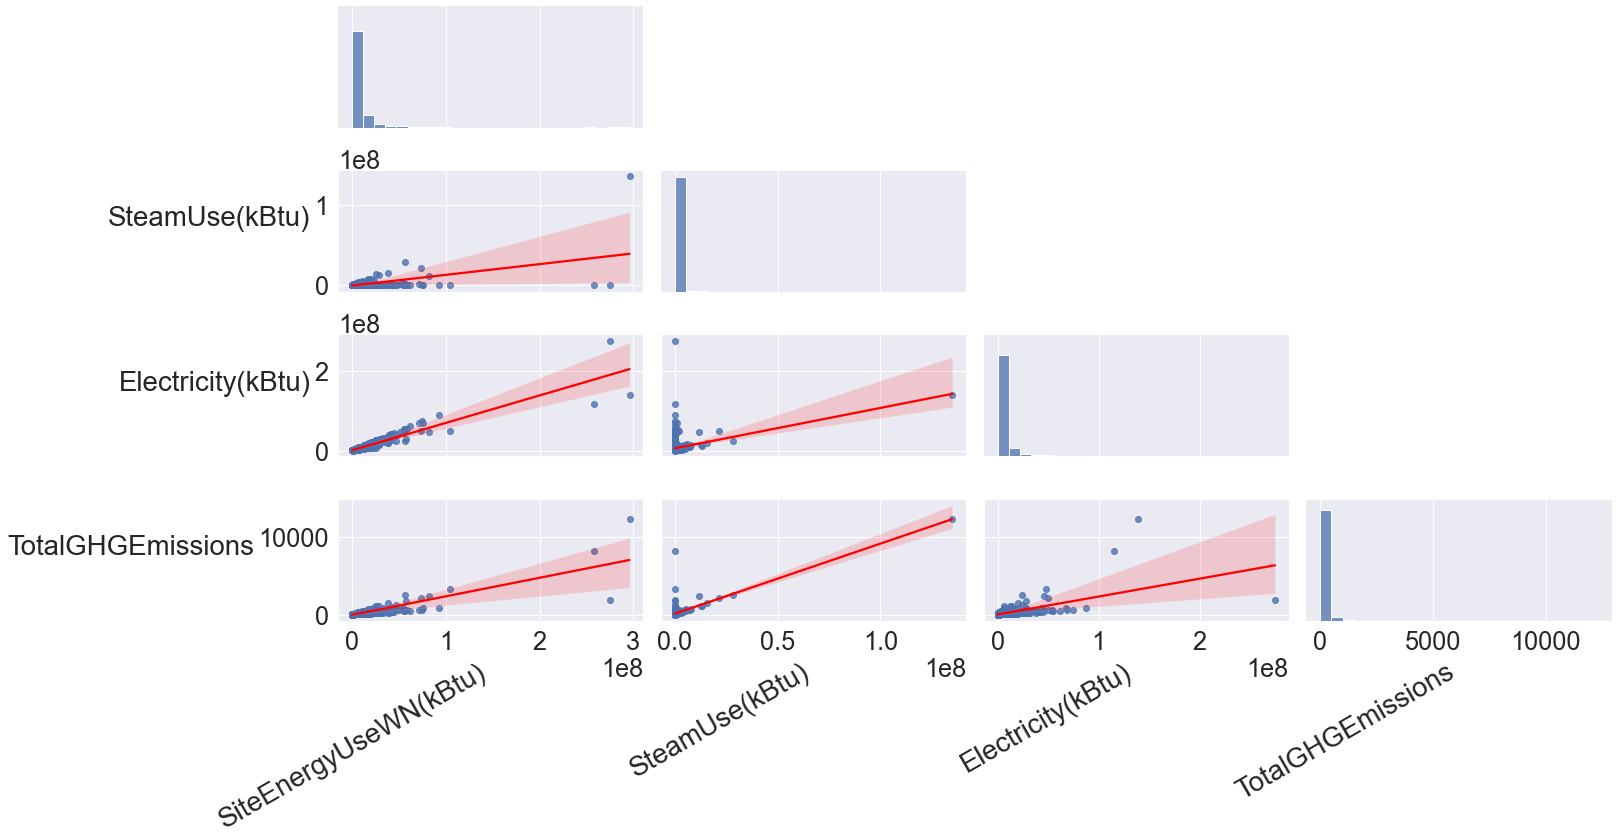

In [55]:
# Analyse de la relation entre les variables (pairplot)

sns.set(font_scale=2.3)

g = sns.pairplot(df[lst_Columns], corner=True,kind='reg',plot_kws={'line_kws':{'color':'red'}},
                diag_kind = "hist", diag_kws = {'bins':25},aspect=2)
g.tight_layout()

for ax in g.axes.flatten():
    if ax:
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation = 30)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation = 0)
        # set y labels alignment
        ax.yaxis.get_label().set_horizontalalignment('right')
        # set x labels alignment
        ax.xaxis.get_label().set_horizontalalignment('right')

In [56]:
df.head()

DataYear    BuildingType PrimaryPropertyType          Address     City  \
0      2016  NonResidential               Hotel    405 Olive way  Seattle   
1      2016  NonResidential               Hotel  724 Pine street  Seattle   
2      2016  NonResidential               Hotel  1900 5th Avenue  Seattle   
3      2016  NonResidential               Hotel   620 STEWART ST  Seattle   
4      2016  NonResidential               Hotel    401 LENORA ST  Seattle   

  State  ZipCode CouncilDistrictCode Neighborhood  Latitude  Longitude  \
0    WA  98101.0                   7     DOWNTOWN  47.61220 -122.33799   
1    WA  98101.0                   7     DOWNTOWN  47.61317 -122.33393   
2    WA  98101.0                   7     DOWNTOWN  47.61393 -122.33810   
3    WA  98101.0                   7     DOWNTOWN  47.61412 -122.33664   
4    WA  98121.0                   7     DOWNTOWN  47.61375 -122.34047   

   YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0       1927                1.0              12             88434   
1       1996                1.0              11            103566   
2       1969                1.0              41            956110   
3       1926                1.0              10             61320   
4       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SteamUse(kBtu)  \
0                      NaN             60.0      2003882.00   
1                      NaN             61.0            0.00   
2                      NaN             43.0     21566554.00   
3                      NaN             56.0      2214446.25   
4                      NaN             75.0            0.00   

   Electricity(kBtu)  NaturalGas(therms)  Comments  TotalGHGEmissions  \
0          3946027.0         12764.52930       NaN             249.98   
1          3242851.0         51450.81641       NaN             295.86   
2         49526664.0         14938.00000       NaN            2089.28   
3          2768924.0         18112.13086       NaN             286.43   
4          5368607.0         88039.98438       NaN             505.01   

   SiteEnergyUseWN(kBtu)  Parking_per  Largest_UseType_per  
0              7456910.0        0.000                1.000  
1              8664479.0        0.145                0.810  
2             73937112.0        0.206                0.791  
3           

### V- Nettoyage

#### Supression lignes Type =! NaN MAIS TypeGFA = 0 ou NaN
##### SecondLargestPropertyUseType
On vérifie si on a pas des cas ou SecondLargestPropertyUseType =! NaN mais que SecondLargestPropertyUseTypeGFA = 0 ou NaN

In [57]:
# Sélectionner les lignes où SecondLargestPropertyUseType n'est pas égal à 0
condition1 = ~df['SecondLargestPropertyUseType'].isna()

# Sélectionner les lignes où SecondLargestPropertyUseTypeGFA est égal à NaN ou à 0
condition2 = df['SecondLargestPropertyUseTypeGFA'].isna() | (df['SecondLargestPropertyUseTypeGFA'] == 0)

# Appliquer les deux conditions pour filtrer le dataframe
result = df[condition1 & condition2]
result.shape[0]

38

In [58]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df = df.drop(result.index)
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 871
Nombre de lignes après la suppression : 833


##### ThirdLargestPropertyUseType
On vérifie si on a pas des cas ou ThirdLargestPropertyUseType =! NaN mais que ThirdLargestPropertyUseTypeGFA = 0 ou NaN

In [59]:
# Sélectionner les lignes où SecondLargestPropertyUseType n'est pas égal à 0
condition1 = ~df['ThirdLargestPropertyUseType'].isna()

# Sélectionner les lignes où SecondLargestPropertyUseTypeGFA est égal à NaN ou à 0
condition2 = df['ThirdLargestPropertyUseTypeGFA'].isna() | (df['ThirdLargestPropertyUseTypeGFA'] == 0)

# Appliquer les deux conditions pour filtrer le dataframe
result = df[condition1 & condition2]
result.shape[0]


12

In [60]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df = df.drop(result.index)
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 833
Nombre de lignes après la suppression : 821


In [61]:
df

DataYear        BuildingType PrimaryPropertyType               Address  \
0         2016      NonResidential               Hotel         405 Olive way   
1         2016      NonResidential               Hotel       724 Pine street   
2         2016      NonResidential               Hotel       1900 5th Avenue   
3         2016      NonResidential               Hotel        620 STEWART ST   
6         2016      NonResidential               Hotel       1619 9th Avenue   
...        ...                 ...                 ...                   ...   
3320      2016      NonResidential              Office  325 9th Avenue North   
3324      2016      NonResidential              Office  400 9th Avenue North   
3329      2016  Nonresidential COS              Office    400 FAIRVIEW AVE N   
3338      2016      NonResidential           Warehouse            6518 Ellis   
3339      2016      NonResidential              Office    7277 Perimeter Rd.   

         City State  ZipCode CouncilDistrictCode      Neighborhood  Latitude  \
0     Seattle    WA  98101.0                   7          DOWNTOWN  47.61220   
1     Seattle    WA  98101.0                   7          DOWNTOWN  47.61317   
2     Seattle    WA  98101.0                   7          DOWNTOWN  47.61393   
3     Seattle    WA  98101.0                   7          DOWNTOWN  47.61412   
6     Seattle    WA  98101.0                   7          DOWNTOWN  47.61390   
...       ...   ...      ...                 ...               ...       ...   
3320  Seattle    WA  98109.0                   7        LAKE UNION  47.62146   
3324  Seattle    WA  98109.0                   7        LAKE UNION  47.62263   
3329  Seattle    WA  98109.0                   7        LAKE UNION  47.62251   
3338  Seattle    WA  98108.0                   2  GREATER DUWAMISH  47.54425   
3339  Seattle    WA  98108.0                   2  GREATER DUWAMISH  47.53161   

      Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
0    -122.33799       1927                1.0              12   
1    -122.33393       1996                1.0              11   
2    -122.33810       1969                1.0              41   
3    -122.33664       1926                1.0              10   
6    -122.33283       1926                1.0              11   
...         ...        ...                ...             ...   
3320 -122.33976       2014                1.0              12   
3324 -122.33976       2015                1.0              12   
3329 -122.33390       2014                1.0              13   
3338 -122.31776       1955                1.0               1   
3339 -122.29944       1929                1.0               2   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0                88434                   0                   88434   
1               103566               15064                   88502   
2               956110              196718                  759392   
3                61320                   0                   61320   
6                83008                   0                   83008   
...                ...                 ...                     ...   
3320            480702              163260                  317442   
3324            483397              166208                  317189   
3329            536697              197659                  339038   
3338             52085                4222                   47863   
3339             24990                   0                   24990   

          ListOfAllPropertyUseTypes      LargestPropertyUseType  \
0                             Hotel                       Hotel   
1        Hotel, Parking, Restaurant                       Hotel   
2                             Hotel                       Hotel   
3                             Hotel                       Hotel   
6                             Hotel                       Hotel   
...                             ...                         

#### Transformation des NaN en 0

In [62]:
# Comptez les valeurs manquantes pour chaque colonne
nb_nan_par_colonne = df.isna().sum()

# Affichez le résultat
print(nb_nan_par_colonne)

DataYear                             0
BuildingType                         0
PrimaryPropertyType                  0
Address                              0
City                                 0
State                                0
ZipCode                              0
CouncilDistrictCode                  0
Neighborhood                         0
Latitude                             0
Longitude                            0
YearBuilt                            0
NumberofBuildings                    0
NumberofFloors                       0
PropertyGFATotal                     0
PropertyGFAParking                   0
PropertyGFABuilding(s)               0
ListOfAllPropertyUseTypes            0
LargestPropertyUseType               0
LargestPropertyUseTypeGFA            0
SecondLargestPropertyUseType       423
SecondLargestPropertyUseTypeGFA    423
ThirdLargestPropertyUseType        687
ThirdLargestPropertyUseTypeGFA     687
YearsENERGYSTARCertified           736
ENERGYSTARScore          

SecondLargestPropertyUseTypeGFA et ThirdLargestPropertyUseTypeGFA ont des NaN, ce qui signifie que leur surface est nulle, on transforme ces NaN en zero

In [63]:
df['SecondLargestPropertyUseTypeGFA'] = df['SecondLargestPropertyUseTypeGFA'].fillna(0)
df['ThirdLargestPropertyUseTypeGFA'] = df['ThirdLargestPropertyUseTypeGFA'].fillna(0)

In [64]:
count_unique = df.nunique()

# Filtrer les colonnes avec une seule valeur unique
columns_with_single_value = count_unique[count_unique == 1].index.tolist()

# Afficher les noms des colonnes avec leur valeur unique
for column in columns_with_single_value:
    unique_value = df[column].unique()[0]
    print(f"Colonne : {column}, Valeur unique : {unique_value}")


Colonne : DataYear, Valeur unique : 2016
Colonne : City, Valeur unique : Seattle
Colonne : State, Valeur unique : WA


In [65]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(columns=columns_with_single_value)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 34
Nombre de colonnes après la suppression : 31


In [66]:
df.head()

BuildingType PrimaryPropertyType          Address  ZipCode  \
0  NonResidential               Hotel    405 Olive way  98101.0   
1  NonResidential               Hotel  724 Pine street  98101.0   
2  NonResidential               Hotel  1900 5th Avenue  98101.0   
3  NonResidential               Hotel   620 STEWART ST  98101.0   
6  NonResidential               Hotel  1619 9th Avenue  98101.0   

  CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
0                   7     DOWNTOWN  47.61220 -122.33799       1927   
1                   7     DOWNTOWN  47.61317 -122.33393       1996   
2                   7     DOWNTOWN  47.61393 -122.33810       1969   
3                   7     DOWNTOWN  47.61412 -122.33664       1926   
6                   7     DOWNTOWN  47.61390 -122.33283       1926   

   NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                1.0              12             88434                   0   
1                1.0              11            103566               15064   
2                1.0              41            956110              196718   
3                1.0              10             61320                   0   
6                1.0              11             83008                   0   

   PropertyGFABuilding(s)   ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                   88434                       Hotel                  Hotel   
1                   88502  Hotel, Parking, Restaurant                  Hotel   
2                  759392                       Hotel                  Hotel   
3                   61320                       Hotel                  Hotel   
6                   83008                       Hotel                  Hotel   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                          NaN   
1                    83880.0                      Parking   
2                   756493.0                          NaN   
3                    61320.0                          NaN   
6                    81352.0                          NaN   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                              0.0                         NaN   
1                          15064.0                  Restaurant   
2                              0.0                         NaN   
3                              0.0                         NaN   
6                              0.0                         NaN   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             0.0                      NaN             60.0   
1                          4622.0                      NaN             61.0   
2                             0.0                      NaN             43.0   
3                             0.0                      NaN             56.0   
6                             0.0                      NaN             27.0   

   SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(therms)  Comments  \
0      2003882.00          3946027.0         12764.52930       NaN   
1            0.00          3242851.0         51450.81641       NaN   
2     21566554.00         49526664.0         14938.00000       NaN   
3      2214446.25          2768924.0         18112.13086       NaN   
6            0.00          2811215.0         29475.80078       NaN   

   TotalGHGEmissions  SiteEnergyUseWN(kBtu)  Parking_per  Largest_UseType_per  
0             249.98              7456910.0        0.000                1.000  
1             295.86              8664479.0        0.145                0.810  
2            2089.28             73937112.0        0.206                0.791  
3             286.43              6946800.5        0.000                1.000  
6             176.14              6062767.5        0.000                0.980

#### Supression des lignes (Parking)
On va supprimer les lignes ou on a une surface de Parking > 0 mais ou c'est indiqué nul part qu'on utilise cette surface 

In [67]:
df_filtered = df[df['PropertyGFAParking'] != 0]
df_filtered = df_filtered[(df_filtered["LargestPropertyUseType"] != "Parking") & (df_filtered["SecondLargestPropertyUseType"] !=  "Parking") & (df_filtered["ThirdLargestPropertyUseType"] !=  "Parking") & (df_filtered["ThirdLargestPropertyUseTypeGFA"] == 0)]

In [68]:
df_filtered_head = df_filtered.loc[:, ['PropertyGFAParking', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType' , 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']]
df_filtered_head.head()

PropertyGFAParking LargestPropertyUseType  LargestPropertyUseTypeGFA  \
2               196718                  Hotel                   756493.0   
10               19279                  Hotel                   133884.0   
27               38281                  Hotel                   128909.0   
29               16200                  Hotel                    47994.0   
53               34735                  Hotel                   107547.0   

   SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
2                           NaN                              0.0   
10                          NaN                              0.0   
27                          NaN                              0.0   
29                          NaN                              0.0   
53                   Restaurant                           3000.0   

   ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  
2                          NaN                             0.0  
10                         NaN                             0.0  
27                         NaN                             0.0  
29                         NaN                             0.0  
53                         NaN                             0.0

In [69]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df = df.drop(df_filtered.index)
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 821
Nombre de lignes après la suppression : 768


On va aussi supprimer les lignes ou on n'a pas d'égalité entre PropertyGFAParking (>0) et SecondLargestPropertyUseTypeGFA (Parking)

In [70]:
df_filtered = df.loc[(df['PropertyGFAParking'] != df['SecondLargestPropertyUseTypeGFA']) & (df['SecondLargestPropertyUseType'] == "Parking")  & (df['PropertyGFAParking'] != 0)]

In [71]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df = df.drop(df_filtered.index)
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 768
Nombre de lignes après la suppression : 662


On va maintenant supprimer la colonne PropertyGFAParking (elle ne sert plus a rien)

In [72]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop("PropertyGFAParking", axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 31
Nombre de colonnes après la suppression : 30


#### Suppression colonnes vides

In [73]:
columns_with_only_nan = df.columns[df.isna().all()].tolist()
print("Colonnes avec uniquement des NaN :", columns_with_only_nan)

Colonnes avec uniquement des NaN : ['Comments']


In [74]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(df.columns[df.isna().all()], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 30
Nombre de colonnes après la suppression : 29


In [75]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(columns=['Address', 'ZipCode', 'CouncilDistrictCode'])
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 29
Nombre de colonnes après la suppression : 26


### VI - Statistiques descriptives

In [76]:
df.describe().T

count          mean           std  \
Latitude                         662.0  4.761462e+01  4.768241e-02   
Longitude                        662.0 -1.223326e+02  2.336250e-02   
YearBuilt                        662.0  1.956091e+03  3.199595e+01   
NumberofBuildings                662.0  9.924471e-01  3.412229e-01   
NumberofFloors                   662.0  4.055891e+00  5.862382e+00   
PropertyGFATotal                 662.0  1.017749e+05  1.775316e+05   
PropertyGFABuilding(s)           662.0  9.719989e+04  1.688860e+05   
LargestPropertyUseTypeGFA        662.0  8.180481e+04  1.344674e+05   
SecondLargestPropertyUseTypeGFA  662.0  1.627596e+04  4.692114e+04   
ThirdLargestPropertyUseTypeGFA   662.0  3.055837e+03  1.828215e+04   
ENERGYSTARScore                  662.0  6.312236e+01  2.893367e+01   
SteamUse(kBtu)                   662.0  3.787812e+05  5.330207e+06   
Electricity(kBtu)                662.0  4.744449e+06  1.464914e+07   
NaturalGas(therms)               662.0  1.465614e+04  6.220134e+04   
TotalGHGEmissions                662.0  1.401515e+02  6.082769e+02   
SiteEnergyUseWN(kBtu)            662.0  6.805857e+06  2.056382e+07   
Parking_per                      662.0  2.648338e-02  8.933834e-02   
Largest_UseType_per              662.0  8.666631e-01  1.756182e-01   

                                         min           25%           50%  \
Latitude                            47.50959  4.758262e+01  4.761048e+01   
Longitude                         -122.41182 -1.223411e+02 -1.223332e+02   
YearBuilt                         1900.00000  1.926000e+03  1.960000e+03   
NumberofBuildings                    0.00000  1.000000e+00  1.000000e+00   
NumberofFloors                       0.00000  1.000000e+00  2.000000e+00   
PropertyGFATotal                 20000.00000  2.881025e+04  4.687900e+04   
PropertyGFABuilding(s)           18396.00000  2.814250e+04  4.602500e+04   
LargestPropertyUseTypeGFA        10155.00000  2.557650e+04  4.000000e+04   
SecondLargestPropertyUseTypeGFA      0.00000  0.000000e+00  0.000000e+00   
ThirdLargestPropertyUseTypeGFA       0.00000  0.000000e+00  0.000000e+00   
ENERGYSTARScore                      1.00000  4.400000e+01  6.950000e+01   
SteamUse(kBtu)                       0.00000  0.000000e+00  0.000000e+00   
Electricity(kBtu)                 6138.00000  6.389250e+05  1.354194e+06   
NaturalGas(therms)                   0.00000  0.000000e+00  4.101883e+03   
TotalGHGEmissions                    0.81000  1.664000e+01  4.224500e+01   
SiteEnergyUseWN(kBtu)            79967.89844  1.176584e+06  2.291683e+06   
Parking_per                          0.00000  0.000000e+00  0.000000e+00   
Largest_UseType_per                  0.26500  7.530000e-01  9.790000e-01   

                                          75%           max  
Latitude                         4.765004e+01  4.773387e+01  
Longitude                       -1.223221e+02 -1.222622e+02  
YearBuilt                        1.980750e+03  2.014000e+03  
NumberofBuildings                1.000000e+00  7.000000e+00  
NumberofFloors                   4.000000e+00  5.600000e+01  
PropertyGFATotal                 9.789300e+04  1.765970e+06  
PropertyGFABuilding(s)           9.296300e+04  1.765970e+06  
LargestPropertyUseTypeGFA        8.148250e+04  1.639334e+06  
SecondLargestPropertyUseTypeGFA  1.231675e+04  4.415510e+05  
ThirdLargestPropertyUseTypeGFA   0.000000e+00  3.039100e+05  
ENERGYSTARScore                  8.800000e+01  1.000000e+02  
SteamUse(kBtu)                   0.000000e+00  1.349435e+08  
Electricity(kBtu)                3.883136e+06  2.745325e+08  
NaturalGas(therms)               1.215597e+04  1.381912e+06  
TotalGHGEmissions                1.145900e+02  1.230716e+04  
SiteEnergyUseWN(kBtu)            5.836761e+06  2.959299e+08  
Parking_per                      0.000000e+00  5.130000e-01  
Largest_UseType_per              1.000000e+00  1.000000e+00

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


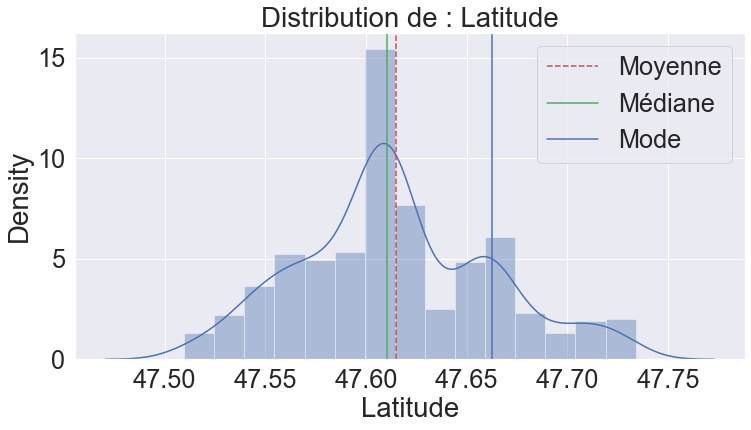

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


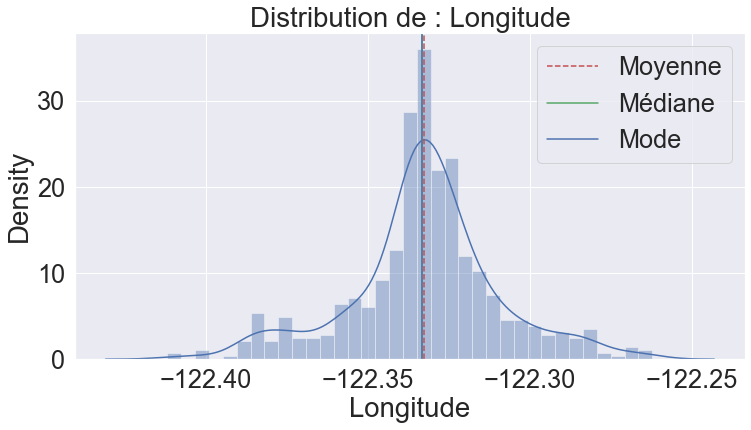

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


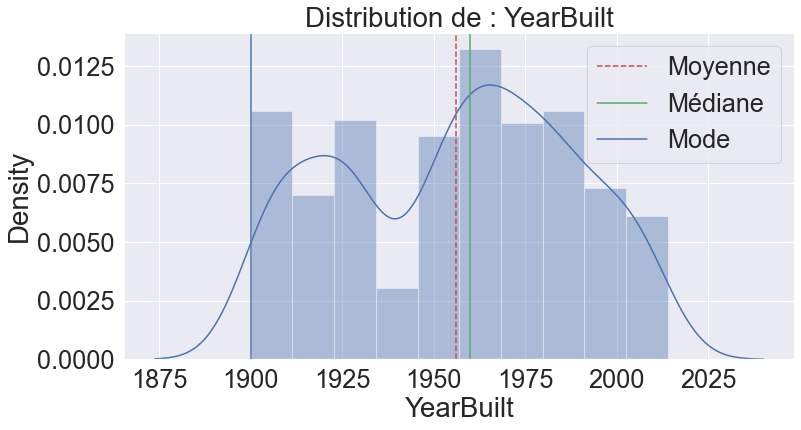

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


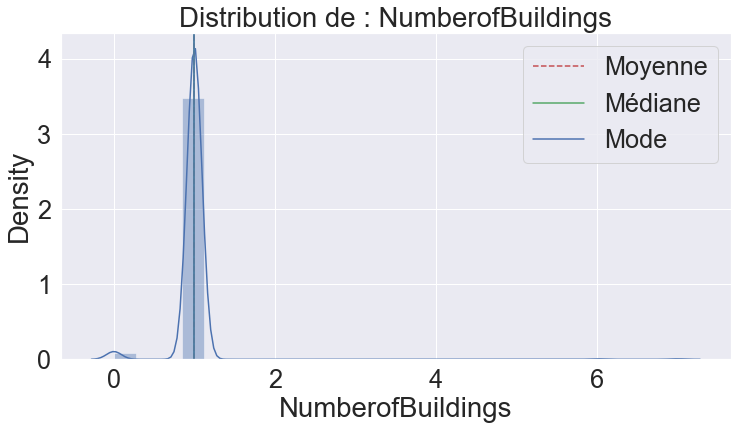

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


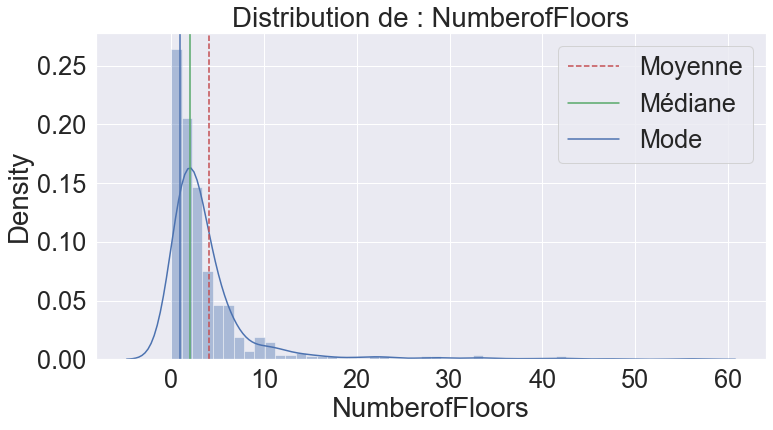

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


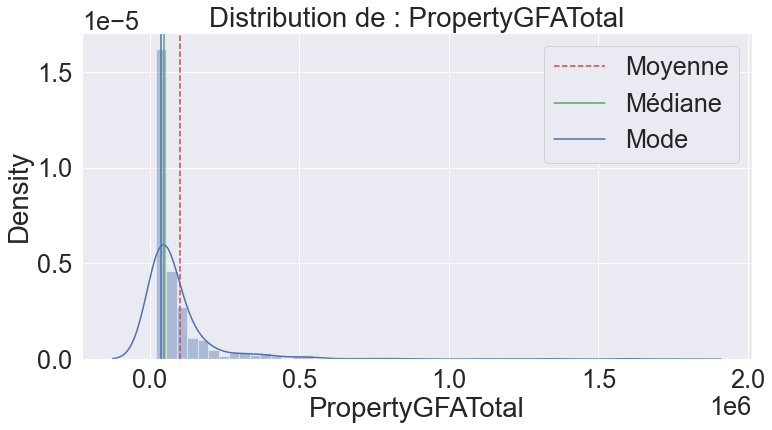

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


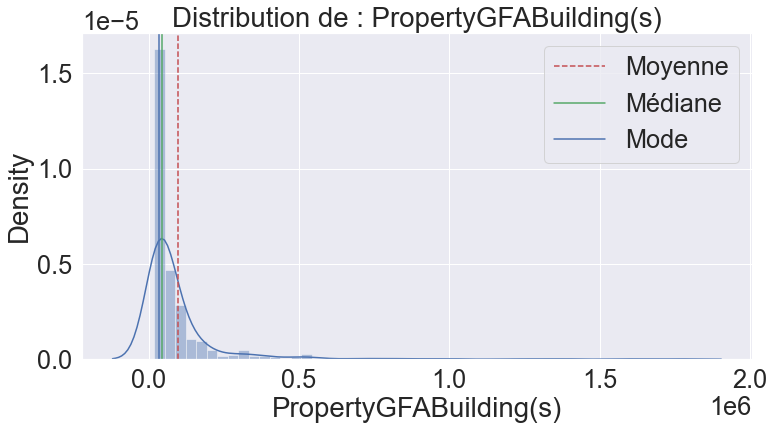

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


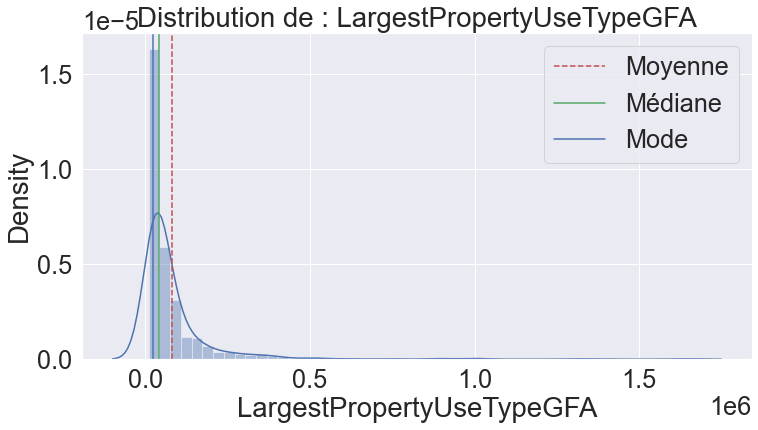

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


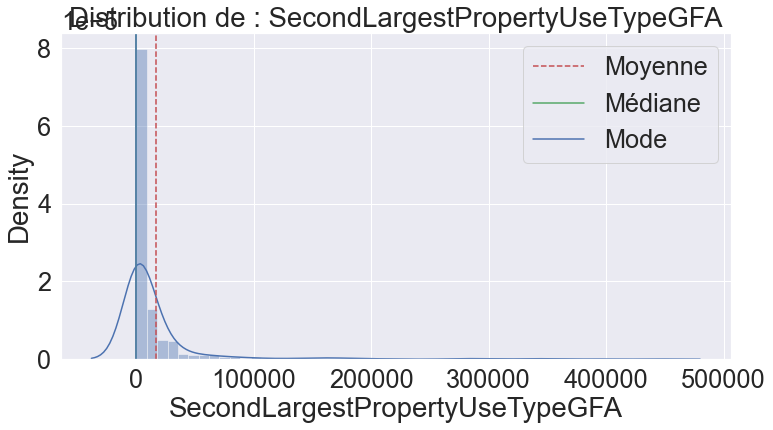

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


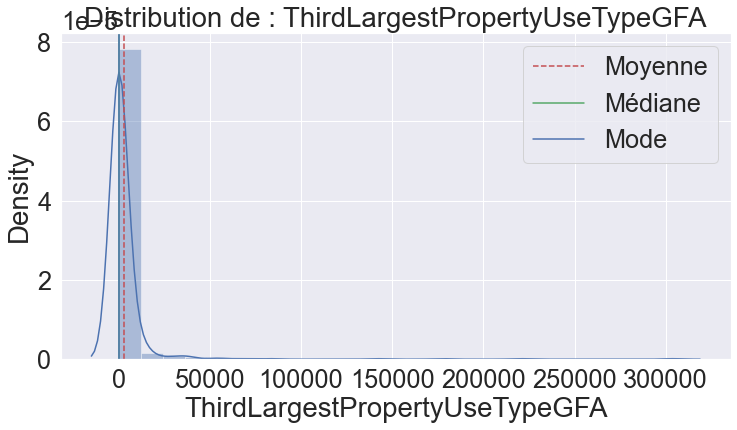

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


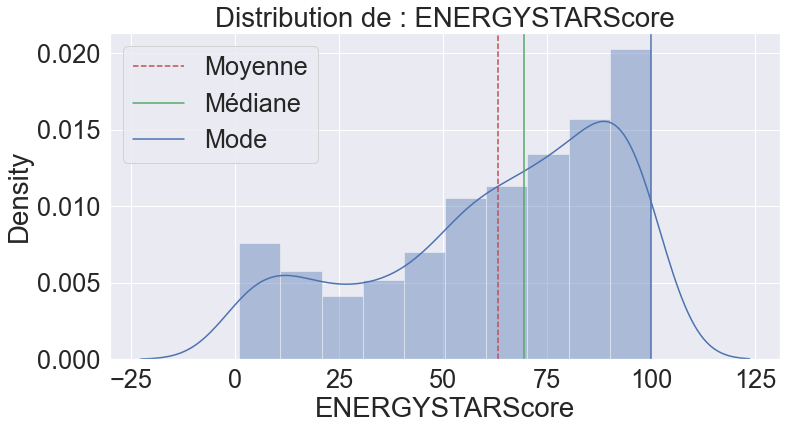

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


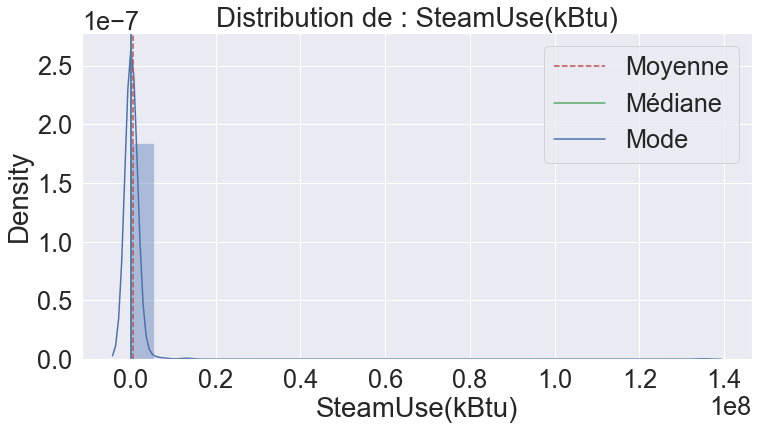

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


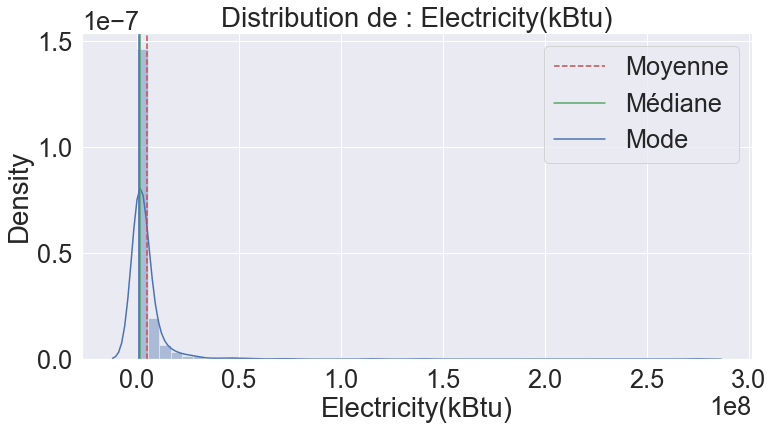

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


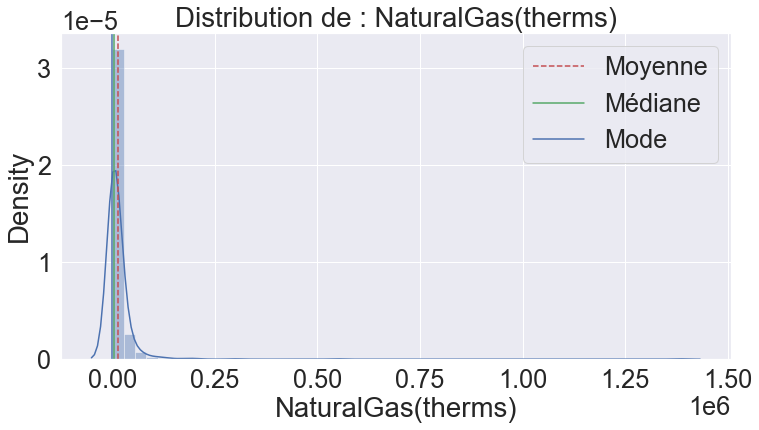

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


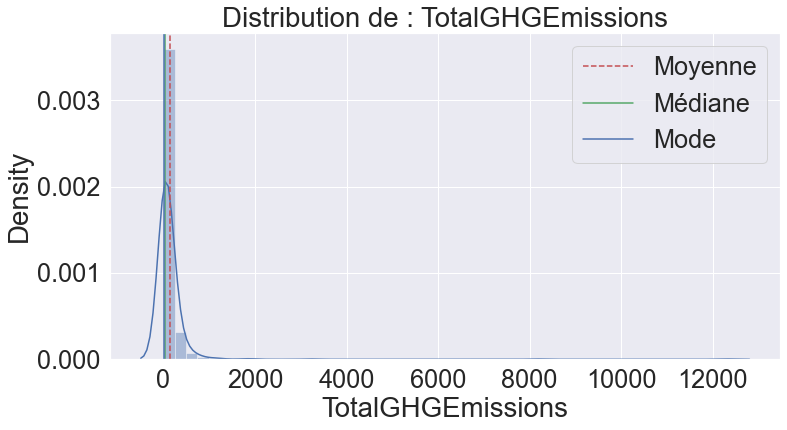

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


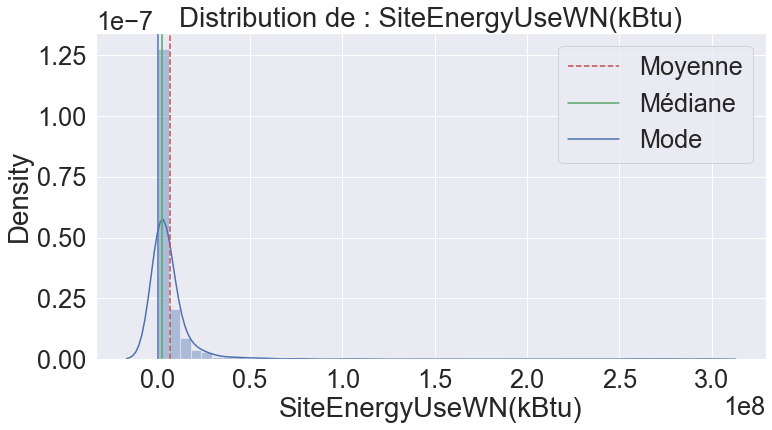

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


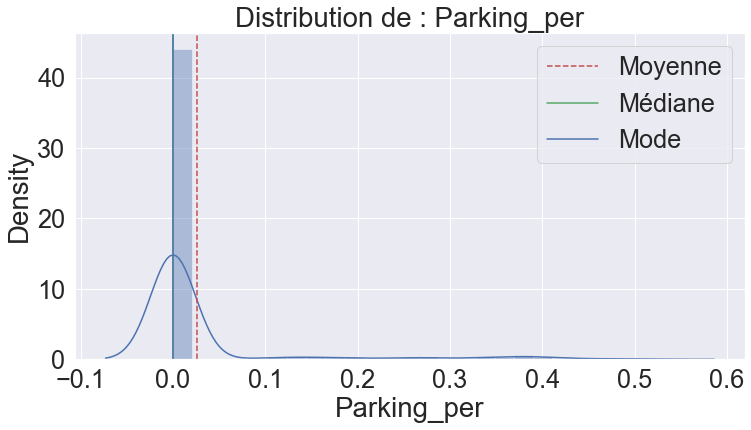

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


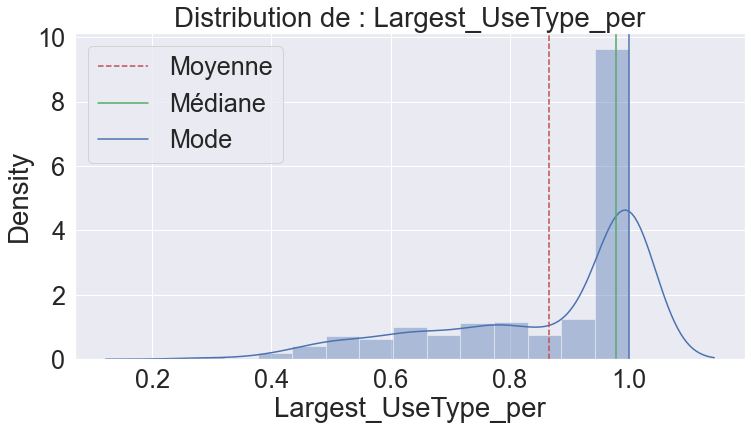

In [77]:
for col in df.select_dtypes("number"):
    plt.figure(figsize = (12,6))
    sns.distplot(df[col])
    plt.axvline(df[col].mean(), color='r', linestyle='--', label="Moyenne")
    plt.axvline(df[col].median(), color='g', linestyle='-', label="Médiane")
    plt.axvline(df[col].mode().values[0], color='b', linestyle='-', label="Mode")
    chaine = 'Distribution de : ' + col
    plt.title(chaine)
    plt.legend()
    plt.show()

In [78]:
def descriptives_stat(dataframe, liste_variables):

    liste_mean = ['moyenne']
    liste_median = ['médiane']
    liste_var = ['variance']
    liste_std = ['écart-type']
    liste_skew = ["skewness : mesure d'asymétrie"]
    liste_kurtosis = ["kurtosis: mesure d'aplatissement"]
    liste_mode = ['mode']
    liste_cols = ['Desc']
    liste_max = ['max']
    liste_min = ['min']
    liste_count = ['count']

    for col in liste_variables:
        liste_mean.append(dataframe[col].mean())
        liste_median.append(dataframe[col].median())
        liste_var.append(dataframe[col].var(ddof=0))
        liste_std.append(dataframe[col].std(ddof=0))
        liste_skew.append(dataframe[col].skew())
        liste_kurtosis.append(dataframe[col].kurtosis())
        liste_cols.append(col)
        liste_mode.append(dataframe[col].mode().values[0])
        liste_min.append(dataframe[col].min())
        liste_max.append(dataframe[col].max())
        liste_count.append(dataframe[col].count())

    data_stats = [liste_count, liste_mean, liste_std, liste_median, liste_min, liste_var,  liste_skew,
                  liste_kurtosis, liste_mode, liste_max]
    df_stat = pd.DataFrame(data_stats, columns=liste_cols)
    
    return df_stat.style.hide_index()

In [79]:
descriptives_stat(df,df.select_dtypes("number"))

C:\Users\elodi\AppData\Local\Temp\ipykernel_10232\1323958847.py:32: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  return df_stat.style.hide_index()


C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


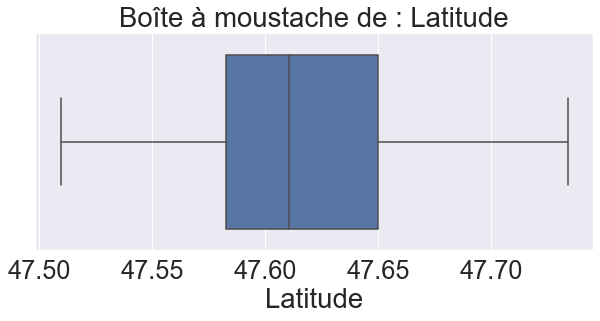

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


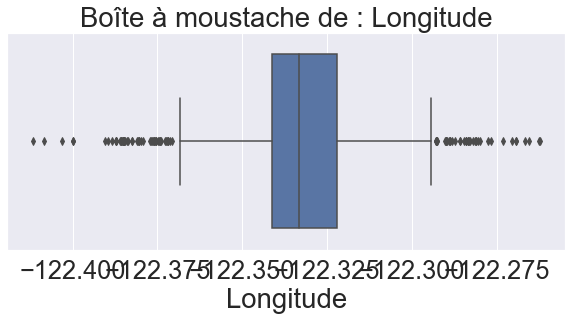

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


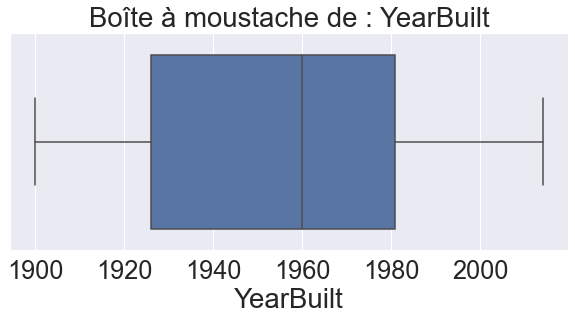

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


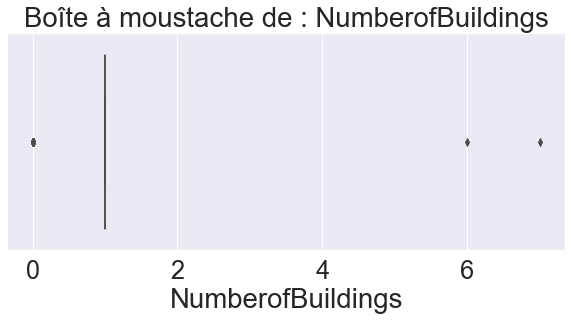

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


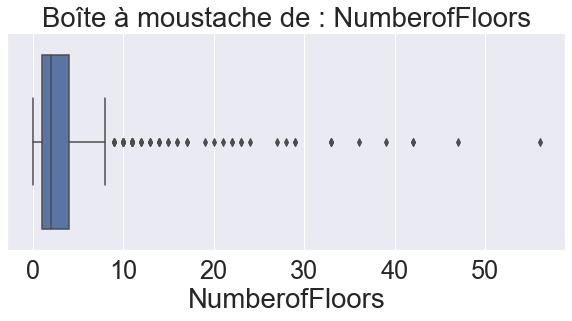

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


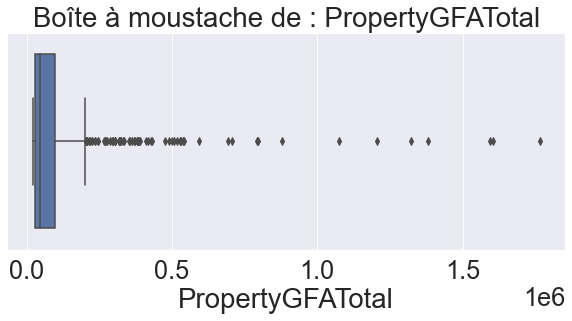

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


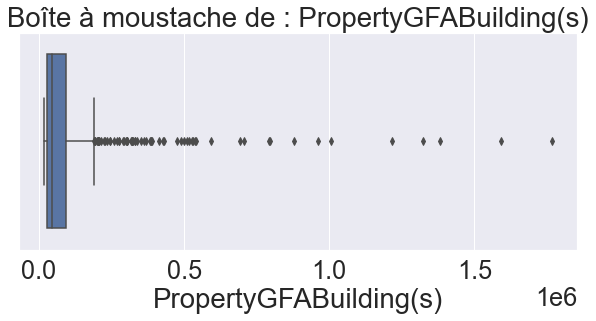

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


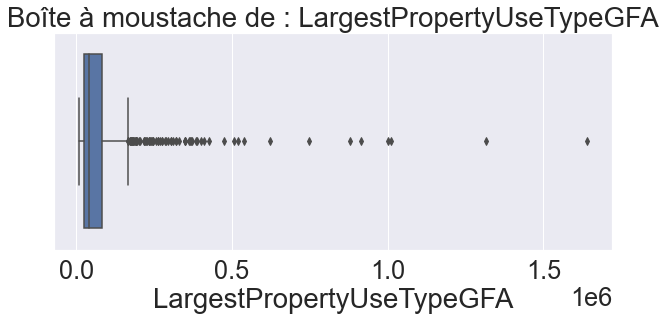

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


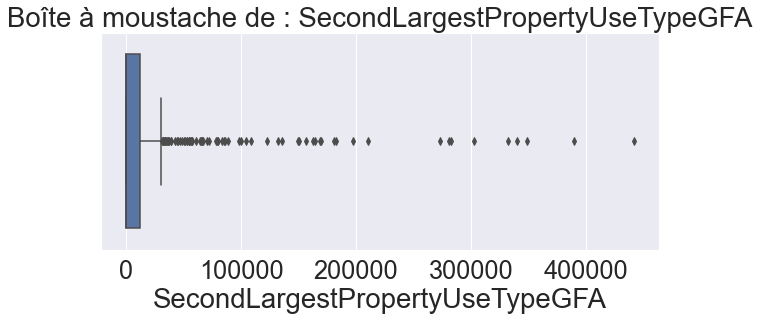

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


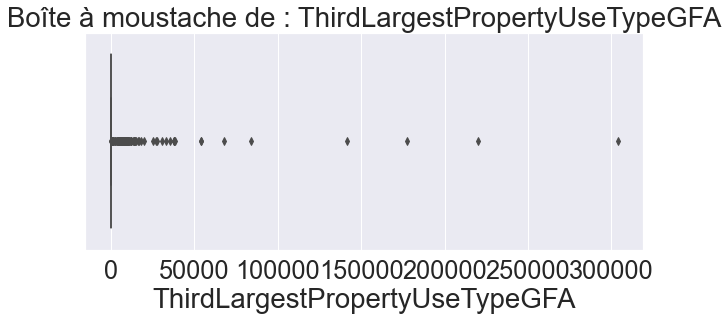

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


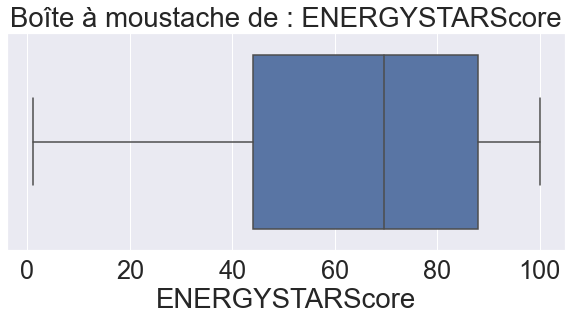

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


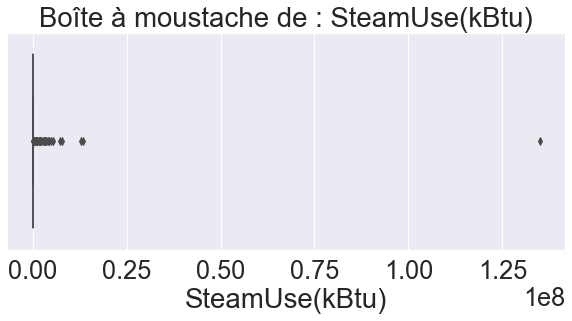

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


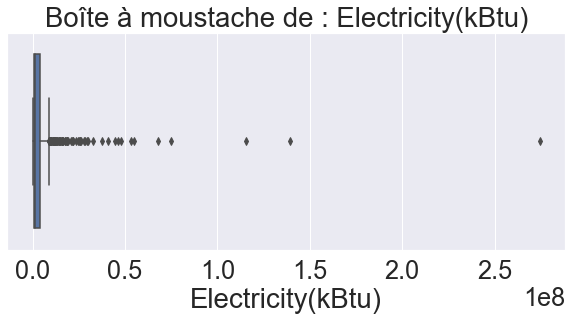

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


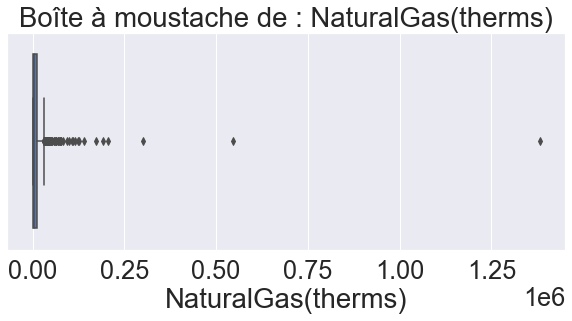

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


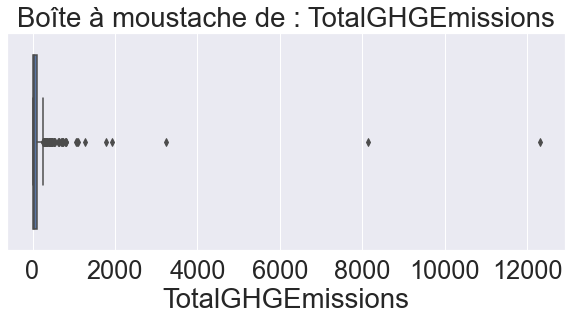

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


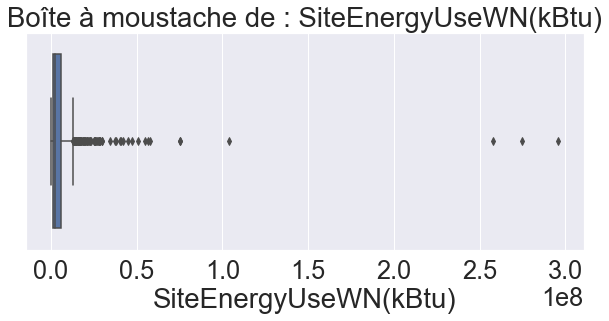

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


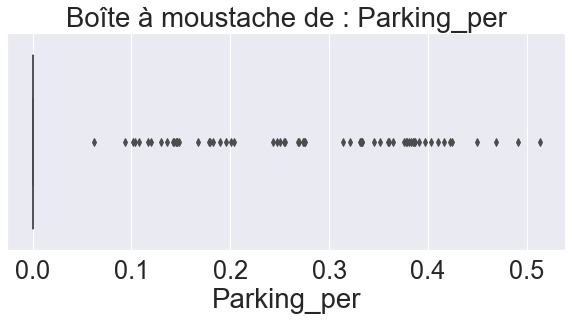

C:\Users\elodi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


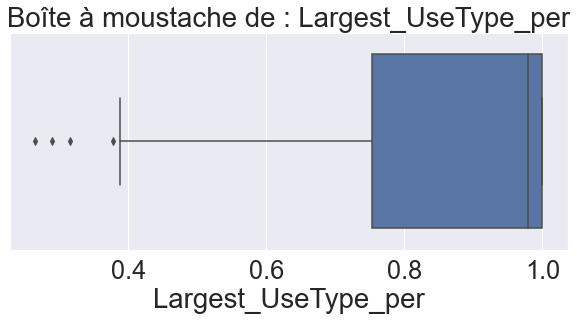

In [80]:
for col in df.select_dtypes("number"):
    plt.figure(figsize = (10,4))
    sns.boxplot(df[col])
    chaine = 'Boîte à moustache de : ' + col
    plt.title(chaine)
    plt.show()

### VII - Création du jeu de données pour la modélisation

In [81]:
lst_variables = ['Longitude','Latitude','PrimaryPropertyType','Neighborhood','Residential',"CouncilDistrictCode",
                 'YearBuilt','Parking_per','Largest_UseType_per','NumberofFloors','NumberofBuildings','PropertyGFATotal',
                 'TotalGHGEmissions','SiteEnergyUseWN(kBtu)','ENERGYSTARScore']
                 

df_model = df[[c for c in df.columns if c in lst_variables]].copy()

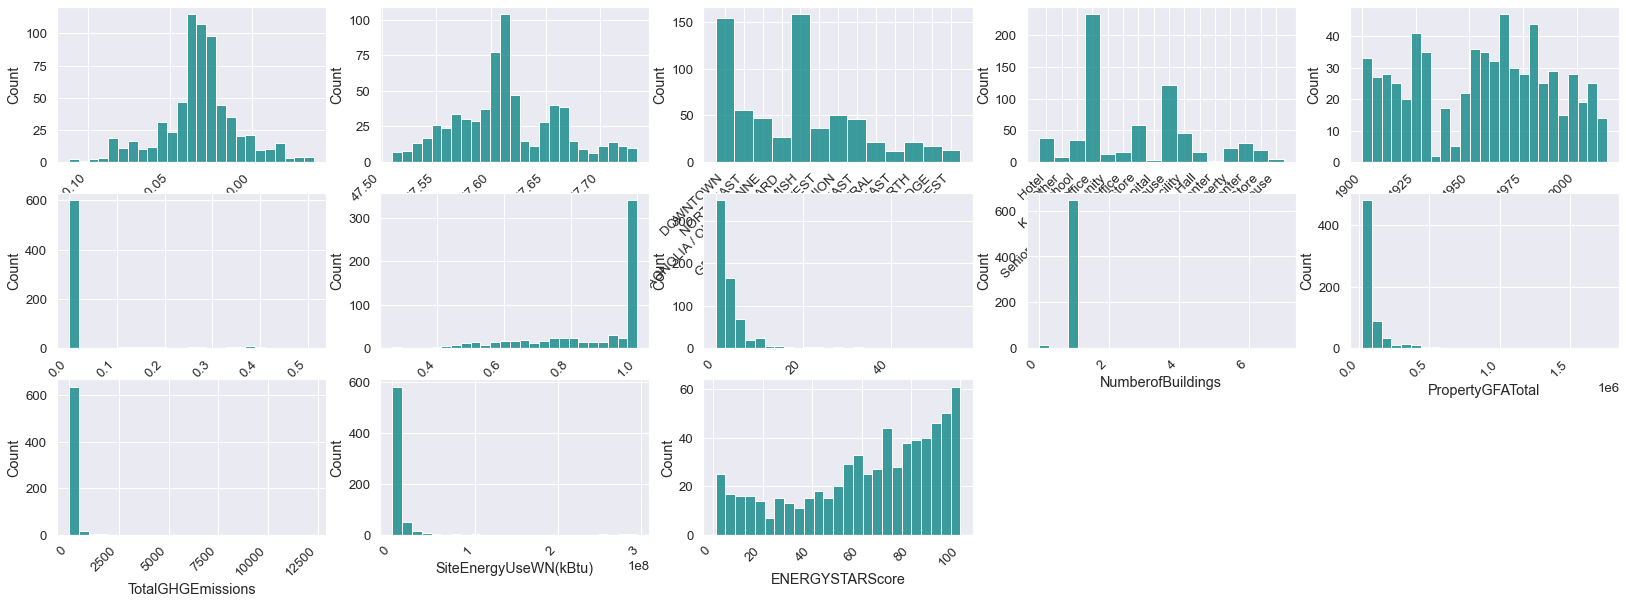

In [82]:
# Répartition empirique des variables selectionnées

lst_variables = ['Longitude','Latitude','Neighborhood','PrimaryPropertyType',
                 'YearBuilt','Parking_per','Largest_UseType_per','NumberofFloors','NumberofBuildings','PropertyGFATotal',
                 'TotalGHGEmissions','SiteEnergyUseWN(kBtu)','ENERGYSTARScore']

n=len(lst_variables)

sns.set(font_scale=1.2)

plt.figure(figsize=(28,20))

for i in range(n):
    col = lst_variables[i]
    ax = plt.subplot(6, 5, i + 1)
    sns.histplot(data=df_model, x=col,
                 bins=25, 
                 color="teal")
    plt.xticks(rotation=45,ha='right')

#plt.tight_layout()
plt.show()

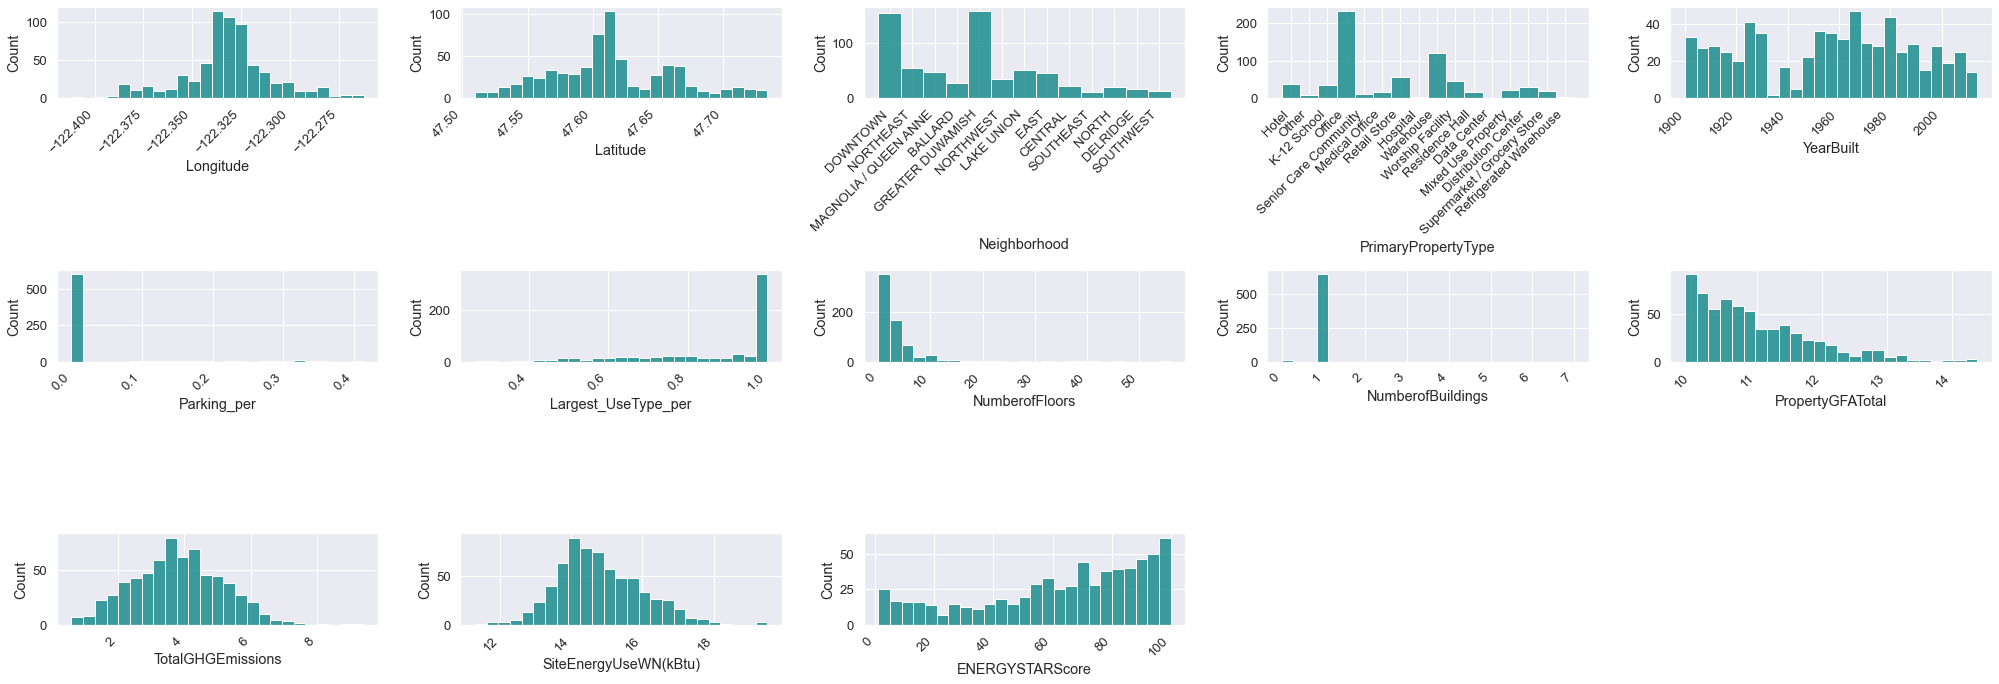

In [83]:
# Transformation de certaines variables numériques en log+1

lst_Columns_fit = ['TotalGHGEmissions','SiteEnergyUseWN(kBtu)',
                   'Parking_per','PropertyGFATotal'
                   ]

for columns in lst_Columns_fit:
    df_model[columns] = np.log1p(df_model[columns])


sns.set(font_scale=1.2)

plt.figure(figsize=(28,20))

for i in range(n):
    col = lst_variables[i]
    ax = plt.subplot(6, 5, i + 1)
    sns.histplot(data=df_model, x=col,
                 bins=25, 
                 color="teal")
    plt.xticks(rotation=45,ha='right')

plt.tight_layout()

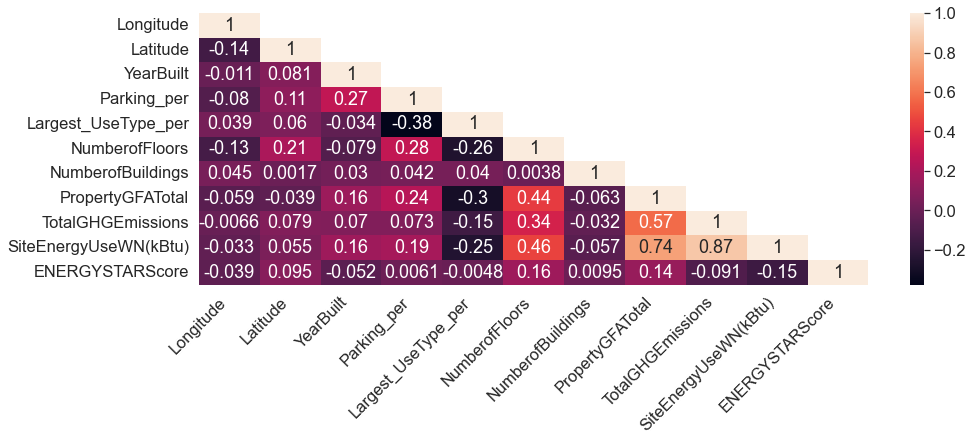

In [84]:
# Mesure du coeficient de corrélation (Non paramétrique : Spearman rank correlation) entre les variables. 

corr = df_model[lst_variables].corr(method='spearman')

mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)

plt.rcParams["figure.figsize"] = (15,5)

sns.set(font_scale=1.5,style='white')
hm = sns.heatmap(corr, annot = True,mask=mask)
hm.set_xticklabels(hm.get_xticklabels(), rotation=45, horizontalalignment='right')
hm.set(xlabel=None,ylabel=None)
plt.show()

In [85]:
#encodage des variables catégorielles

lst_Columns_categ = ['PrimaryPropertyType','Neighborhood']

for columns in lst_Columns_categ:
    df_model = pd.get_dummies(df_model, columns=[columns])


In [86]:
df_model.head()

Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
0  47.61220 -122.33799       1927                1.0              12   
1  47.61317 -122.33393       1996                1.0              11   
3  47.61412 -122.33664       1926                1.0              10   
6  47.61390 -122.33283       1926                1.0              11   
8  47.60294 -122.33263       1904                1.0              15   

   PropertyGFATotal  ENERGYSTARScore  TotalGHGEmissions  \
0         11.390023             60.0           5.525373   
1         11.547974             61.0           5.693261   
3         11.023878             56.0           5.660979   
6         11.326704             27.0           5.176940   
8         12.007530             43.0           5.974217   

   SiteEnergyUseWN(kBtu)  Parking_per  Largest_UseType_per  \
0              15.824652     0.000000                 1.00   
1              15.974742     0.135405                 0.81   
3              15.753792     0.000000                 1.00   
6              15.617677     0.000000                 0.98   
8              16.468334     0.000000                 1.00   

   PrimaryPropertyType_Data Center  PrimaryPropertyType_Distribution Center  \
0                                0                                        0   
1                                0                                        0   
3                                0                                        0   
6                                0                                        0   
8                                0                                        0   

   PrimaryPropertyType_Hospital  PrimaryPropertyType_Hotel  \
0                             0                          1   
1                             0                          1   
3                             0                          1   
6                             0                          1   
8                             0                          1   

   PrimaryPropertyType_K-12 School  PrimaryPropertyType_Medical Office  \
0                                0                                   0   
1                                0                                   0   
3                                0                                   0   
6                                0                                   0   
8                                0                                   0   

   PrimaryPropertyType_Mixed Use Property  PrimaryPropertyType_Office  \
0                                       0                           0   
1                                       0                           0   
3                                       0                           0   
6                                       0                           0   
8                                       0                           0   

   PrimaryPropertyType_Other  PrimaryPropertyType_Refrigerated Warehouse  \
0                          0                                           0   
1                          0                                           0   
3                          0                                           0   
6                          0                                           0   
8                          0                                           0   

   PrimaryPropertyType_Residence Hall  PrimaryPropertyType_Retail Store  \
0                                   0                                 0   
1                                   0                                 0   
3                                   0                                 0   
6                                   0                                 0   
8                                   0                                 0   

   PrimaryPropertyType_Senior Care Community  \
0                                          0   
1                                          0   
3                                          0   
6         

In [87]:

# Fonction conditionnelle pour créer les nouvelles colonnes
def create_usage_column(value):
    if value == 0:
        return 0
    else:
        return 1

# Création des nouvelles colonnes
df_model['SteamUse(kBtu)_Usage'] = df['SteamUse(kBtu)'].apply(create_usage_column)
df_model['Electricity(kBtu)_Usage'] = df['Electricity(kBtu)'].apply(create_usage_column)
df_model['NaturalGas(therms)_Usage'] = df['NaturalGas(therms)'].apply(create_usage_column)

In [88]:
df_model.head()

Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
0  47.61220 -122.33799       1927                1.0              12   
1  47.61317 -122.33393       1996                1.0              11   
3  47.61412 -122.33664       1926                1.0              10   
6  47.61390 -122.33283       1926                1.0              11   
8  47.60294 -122.33263       1904                1.0              15   

   PropertyGFATotal  ENERGYSTARScore  TotalGHGEmissions  \
0         11.390023             60.0           5.525373   
1         11.547974             61.0           5.693261   
3         11.023878             56.0           5.660979   
6         11.326704             27.0           5.176940   
8         12.007530             43.0           5.974217   

   SiteEnergyUseWN(kBtu)  Parking_per  Largest_UseType_per  \
0              15.824652     0.000000                 1.00   
1              15.974742     0.135405                 0.81   
3              15.753792     0.000000                 1.00   
6              15.617677     0.000000                 0.98   
8              16.468334     0.000000                 1.00   

   PrimaryPropertyType_Data Center  PrimaryPropertyType_Distribution Center  \
0                                0                                        0   
1                                0                                        0   
3                                0                                        0   
6                                0                                        0   
8                                0                                        0   

   PrimaryPropertyType_Hospital  PrimaryPropertyType_Hotel  \
0                             0                          1   
1                             0                          1   
3                             0                          1   
6                             0                          1   
8                             0                          1   

   PrimaryPropertyType_K-12 School  PrimaryPropertyType_Medical Office  \
0                                0                                   0   
1                                0                                   0   
3                                0                                   0   
6                                0                                   0   
8                                0                                   0   

   PrimaryPropertyType_Mixed Use Property  PrimaryPropertyType_Office  \
0                                       0                           0   
1                                       0                           0   
3                                       0                           0   
6                                       0                           0   
8                                       0                           0   

   PrimaryPropertyType_Other  PrimaryPropertyType_Refrigerated Warehouse  \
0                          0                                           0   
1                          0                                           0   
3                          0                                           0   
6                          0                                           0   
8                          0                                           0   

   PrimaryPropertyType_Residence Hall  PrimaryPropertyType_Retail Store  \
0                                   0                                 0   
1                                   0                                 0   
3                                   0                                 0   
6                                   0                                 0   
8                                   0                                 0   

   PrimaryPropertyType_Senior Care Community  \
0                                          0   
1                                          0   
3                                          0   
6         

In [89]:
df_model.to_csv('DataCleaned.csv', index=False)